# visualise performance of feature selection strategies

plot metrics for each dataset and strategy for comparison

# imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import pickle
import pathlib as pl
import os

import seaborn as sns 

# utils

In [2]:
def load_pckl(file_name, path=None):
    if path is not None:
        file_name = os.path.join(path, file_name)

    with open(file_name, 'rb') as f:
        data = pickle.load(f)
    return data


def save_pckl(d, file_name, pr=None, path=None):
    if path is not None:
        file_name = os.path.join(path, file_name)

    with open(file_name, 'wb') as f:
        pickle.dump(d, f, protocol=pr if pr is not None else pickle.DEFAULT_PROTOCOL)

# load data

In [3]:
data_root = pl.Path(r'd:\development\napari_convpaint\data')

In [4]:
perf_eval = load_pckl(data_root/'features'/'selected_idx_evaluated.pckl')

In [13]:
# perf_eval is a dict defined like perf_eval[ds][n_features][field]
# fields are ['strategy_name', 'column_idxs', 'strategy_desc', 'metrics'], with related arrays of same lengtgh
# metrics is a list of dicts, with keys 'f1', 'ap', 'p', 'r', 'IoU' to be plotted


inspect data

In [7]:
ds = 'actin'
n_features = 20
perf_eval_ds_n = perf_eval[ds][n_features]
list(zip(perf_eval_ds_n['strategy_name'], perf_eval_ds_n['strategy_desc']))

[('std_ratio_sig_to_bg',
  'largest ratio of channel values std in signal region to std in background region'),
 ('std_ratio_sig_to_edge',
  'largest ratio of channel values std in signal region to std in edge region'),
 ('shaps_0_1', 'largest shaps in block 0 to 1'),
 ('shaps_1_65', 'largest shaps in block 1 to 65'),
 ('shaps_65_129', 'largest shaps in block 65 to 129'),
 ('shaps_129_385', 'largest shaps in block 129 to 385'),
 ('shaps_385_897', 'largest shaps in block 385 to 897'),
 ('shaps_897_1409', 'largest shaps in block 897 to 1409'),
 ('shaps_1409_1473', 'largest shaps in block 1409 to 1473'),
 ('shaps_1473_1537', 'largest shaps in block 1473 to 1537'),
 ('shaps_1537_1793', 'largest shaps in block 1537 to 1793'),
 ('shaps_1793_2305', 'largest shaps in block 1793 to 2305'),
 ('shaps_2305_2817', 'largest shaps in block 2305 to 2817'),
 ('shaps_2817_2818', 'largest shaps in block 2817 to 2818'),
 ('shaps_2818_2882', 'largest shaps in block 2818 to 2882'),
 ('shaps_2882_2946', 'lar

In [8]:
len(perf_eval_ds_n['strategy_name'])

51

# prepare data for plotting

In [9]:
# make dataframes with columns: dataset, n_features, strategy_name, strategy_desc, and each of the metrics
d = {'dataset': [], 'n_features': [], 'strategy_name': [], 'strategy_desc': [], 'f1': [], 'ap': [], 'p': [], 'r': [], 'IoU': []}

for ds in perf_eval.keys():
    for n_features in perf_eval[ds].keys():
        perf_eval_ds_n = perf_eval[ds][n_features]
        for i in range(len(perf_eval_ds_n['strategy_name'])):
            d['dataset'].append(ds)
            d['n_features'].append(n_features)
            d['strategy_name'].append(perf_eval_ds_n['strategy_name'][i])
            d['strategy_desc'].append(perf_eval_ds_n['strategy_desc'][i])
            
            metrics = perf_eval_ds_n['metrics'][i]
            d['f1'].append(metrics['f1'])
            d['ap'].append(metrics['ap'])
            d['p'].append(metrics['p'])
            d['r'].append(metrics['r'])
            d['IoU'].append(metrics['IoU'])
            
df = pd.DataFrame(d)            

In [88]:
# function to plot each metric on subplots for a given dataset using seaborn barplot, with hue=n_features

def plot_metric(df, ds, y_strategy='fit', x_strategy='original', pdf=None):
    """
    Plot metrics for a given dataset using seaborn barplot, with hue=n_features
    
    Parameters
    ----------
    df (pd.DataFrame): dataframe with columns: dataset, n_features, strategy_name, strategy_desc, and each of the metrics
    ds (str): dataset name
    y_strategy (str | int): 'fit', 'all', or number of highest values to from each hue to show
    x_strategy (str): 'original' or metric name for sorting x axis values according to that metric highest values for each hue 

    Returns
    -------

    """
    metrics = ['IoU', 'f1', 'p', 'r', 'ap', ]
    n_metrics = len(metrics)
    
    # set figsize to A4 portrait, 300dpi
    figsize = (8.27, 11.69)
    plt.rcParams['figure.dpi'] = 300
    
    fig, axs = plt.subplots(n_metrics, 1, figsize=figsize, sharex=True)
    
    strategy_names = df['strategy_name'].unique()
    
    strategy_best_metrics_vals={}
    for m in metrics:
        # fill array of highest metric values for each hue
        #maintain same order as strategy_names
        strategy_best_metric_vals = [df[m][df['strategy_name']==s].max() for s in strategy_names]
        strategy_best_metrics_vals[m] = np.array(strategy_best_metric_vals)
        
    # set x-axis order according to x_strategy
    if x_strategy == 'original':
        x_order = strategy_names
    else:
        assert x_strategy in metrics, f'x_strategy must be one of {metrics} or "original"'
        strategies_sorting_idx = np.argsort(strategy_best_metrics_vals[x_strategy])[::-1]
        x_order = strategy_names[strategies_sorting_idx]
    
        # print(strategy_best_metrics_vals[x_strategy][strategies_sorting_idx])

    for i, m in enumerate(metrics):
        ax = axs[i]
        
        # set the x-axis order according to the obtained x-axis order
        sns.barplot(x='strategy_name', y=m, hue='n_features', data=df, ax=ax, order=x_order)
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        # remove x-axis label
        ax.set_xlabel('')
        
        strategy_best_metric_vals = strategy_best_metrics_vals[m]
        # get y lower limit for given strategy
        ofs = 0.005
        if y_strategy == 'fit':
            y_min = max(0, strategy_best_metric_vals.min() - ofs)
            y_max = min(1, strategy_best_metric_vals.max() + ofs)
        elif y_strategy == 'all':
            y_min = 0.
            y_max = 1. + ofs
        else:
            sorted_strategy_best_metric_vals = np.sort(strategy_best_metric_vals)
            y_min = sorted_strategy_best_metric_vals[-y_strategy:].min() - ofs
            y_max = sorted_strategy_best_metric_vals[-y_strategy:].max() + ofs        
                        
        ax.set_ylim(y_min, y_max)
        
        # enable grid
        ax.grid(True)
        
        if i == 0:
            ax.legend(loc='lower center', bbox_to_anchor=(0.8, 1), ncol=5, title='N features')
        else:
            ax.get_legend().remove()
        
        # break

    plt.suptitle(f'Dataset <{ds}>. Metrics for the RF classifier')
    
    plt.tight_layout(pad=1.0, w_pad=0.0, h_pad=0)
    
    # save figure
    #plt.savefig(data_root/'features'/f'{ds}_{metric}.png', bbox_inches='tight')
    if pdf is not None:
        pdf.savefig()
    
    plt.show()
    plt.close()

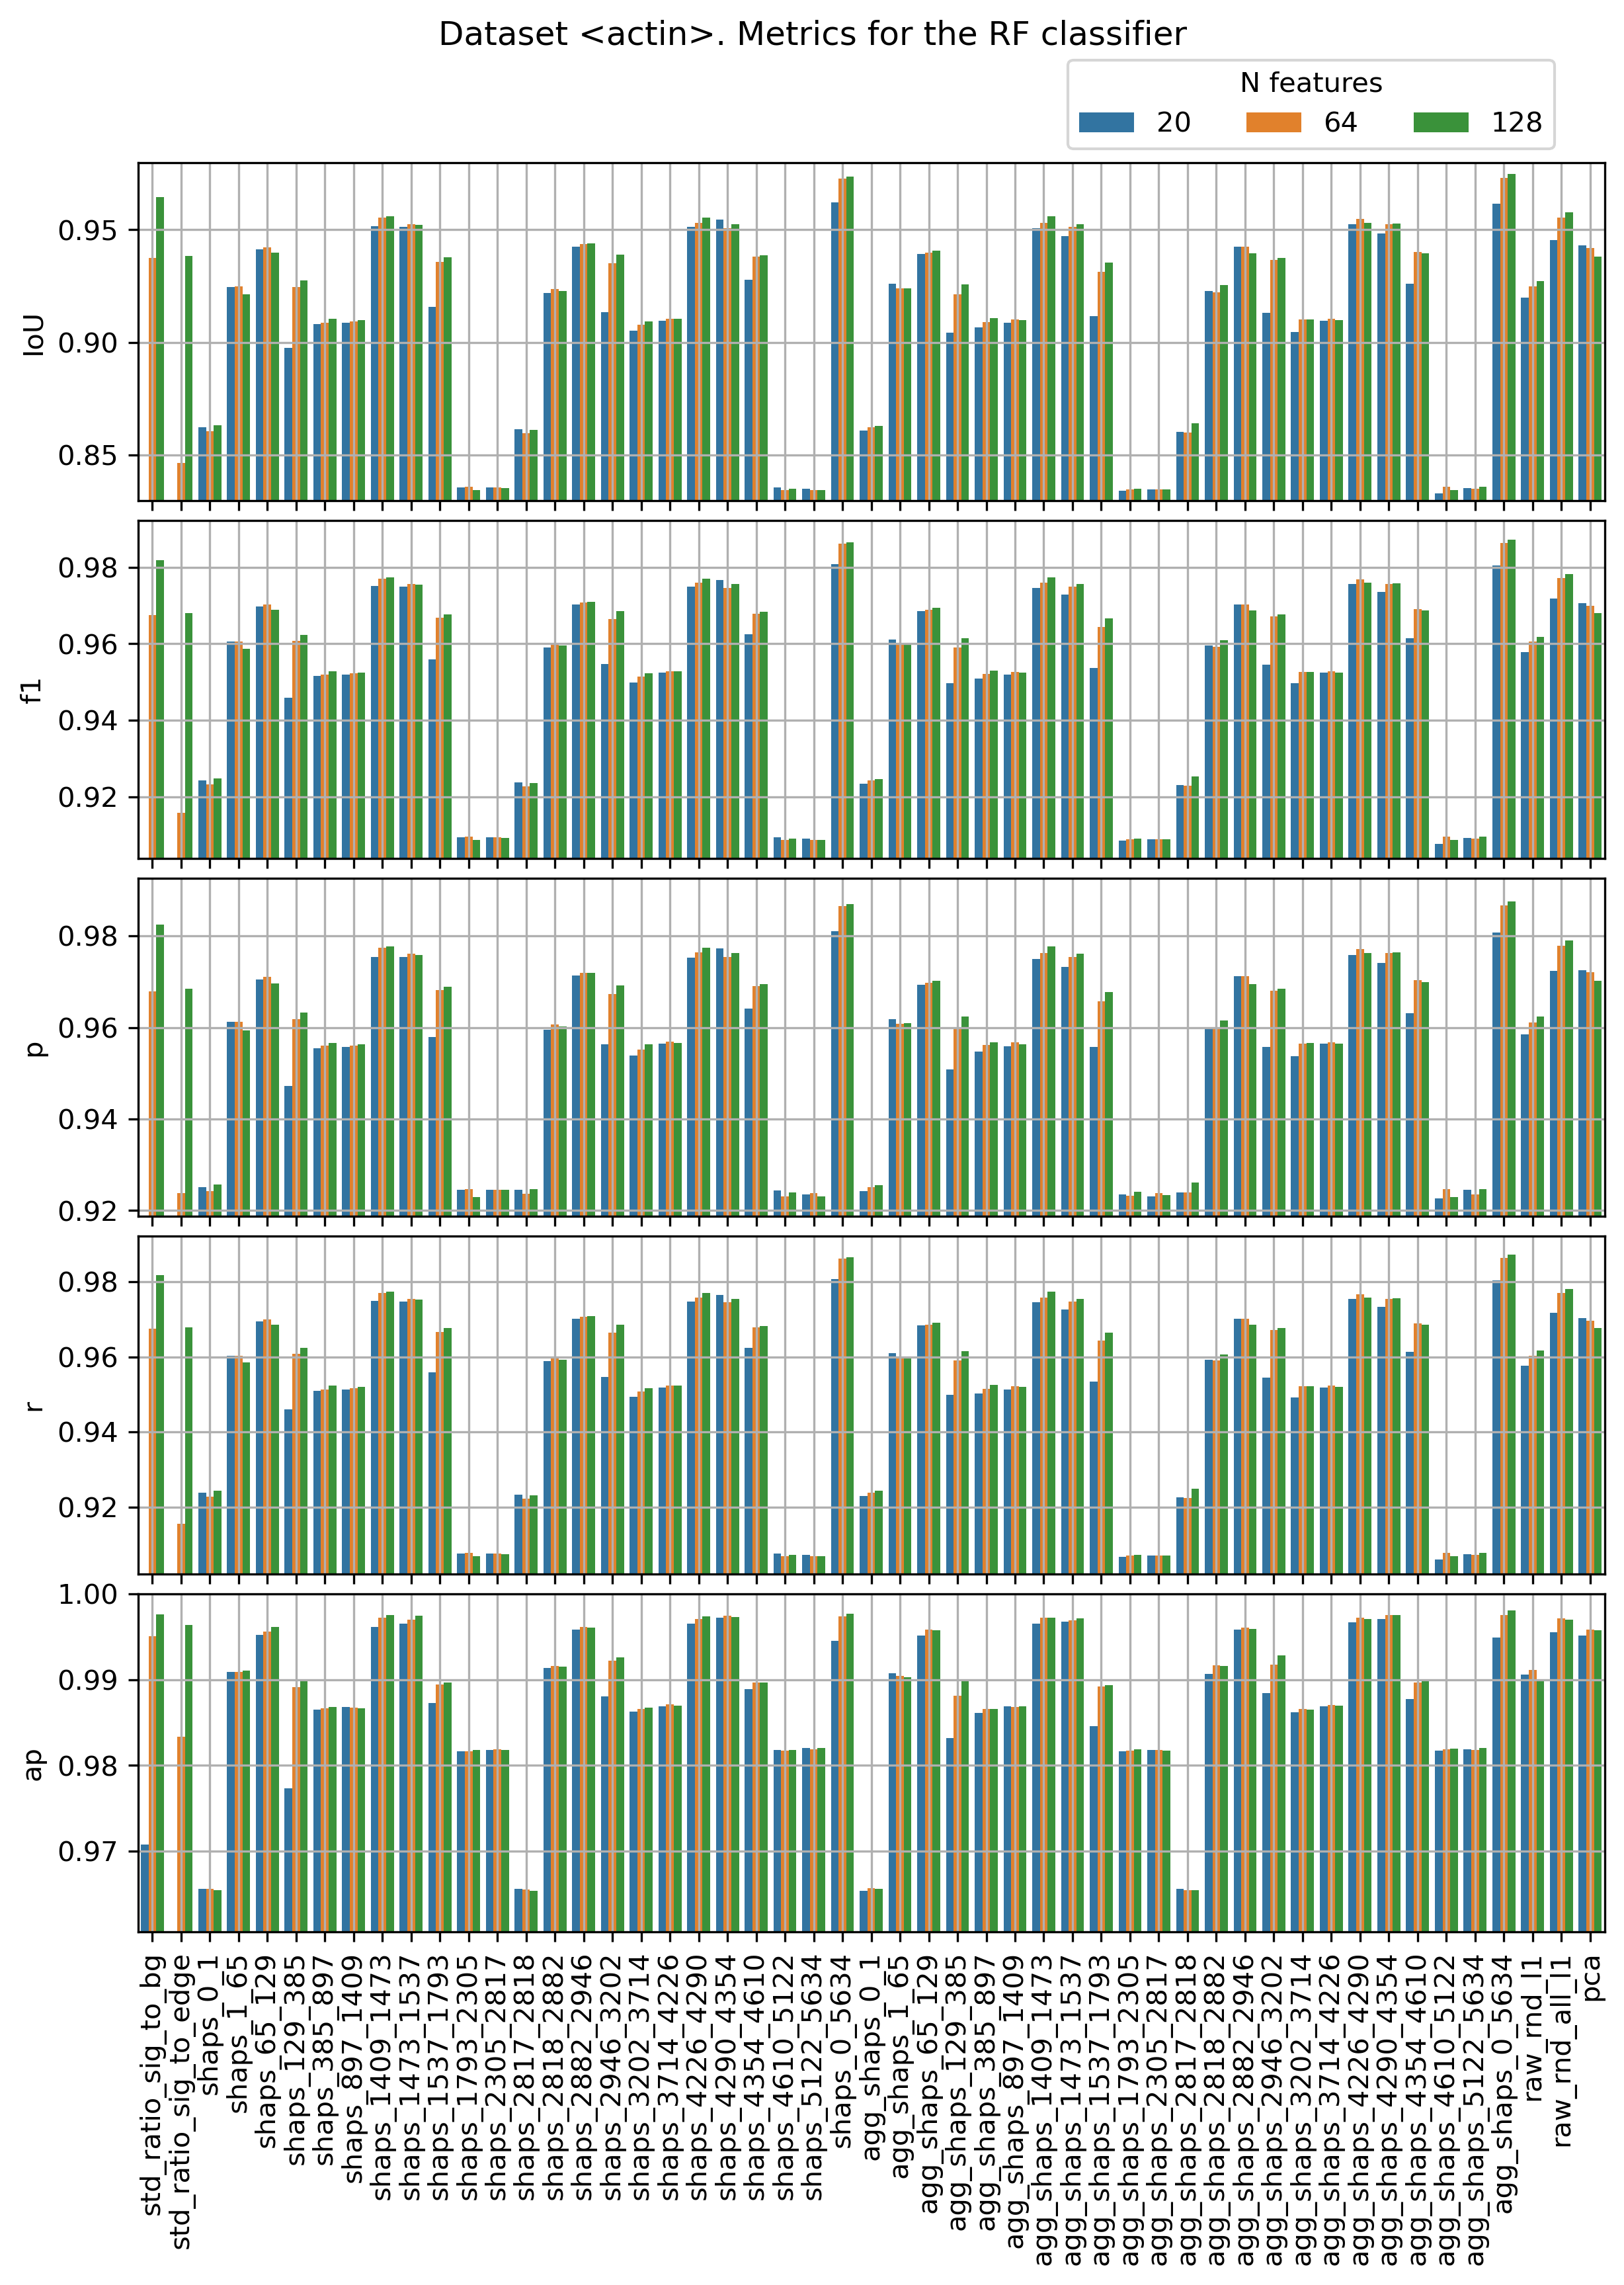

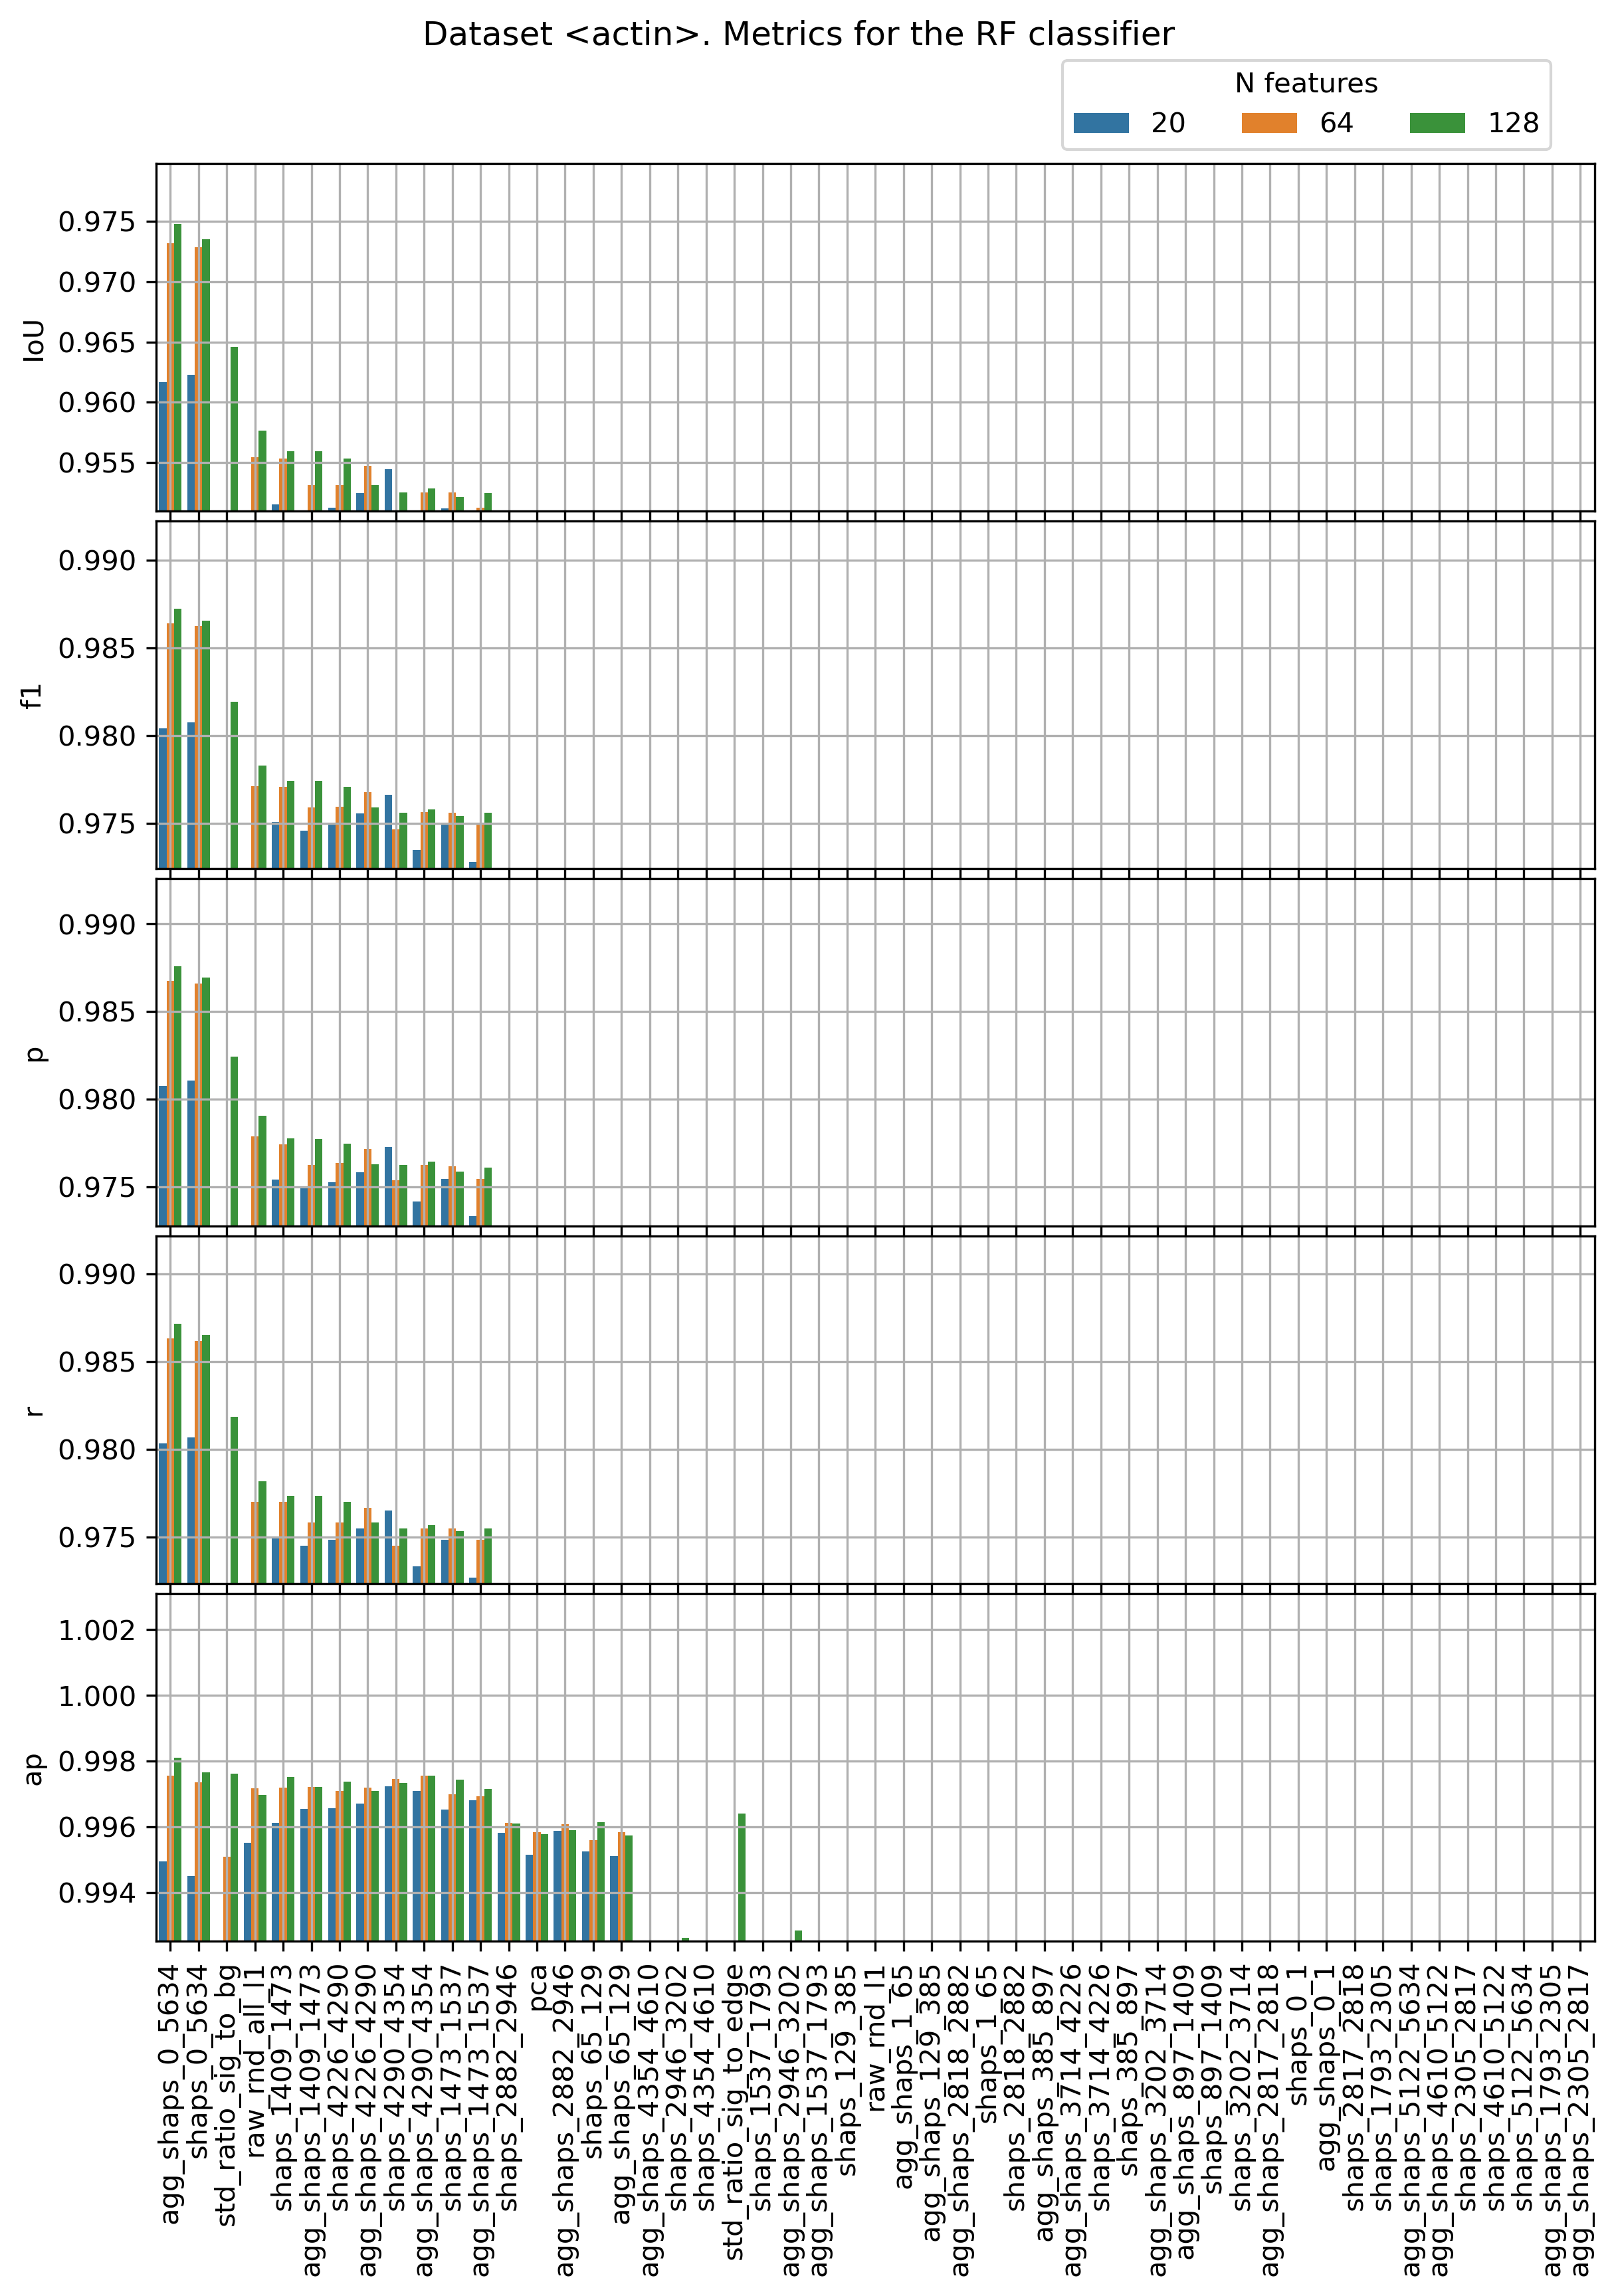

In [89]:
# plot metrics for each dataset
for ds in perf_eval.keys():
    plot_metric(df[df['dataset']==ds], ds, y_strategy='fit')
    plot_metric(df[df['dataset']==ds], ds, y_strategy=5, x_strategy='IoU')
    
    break

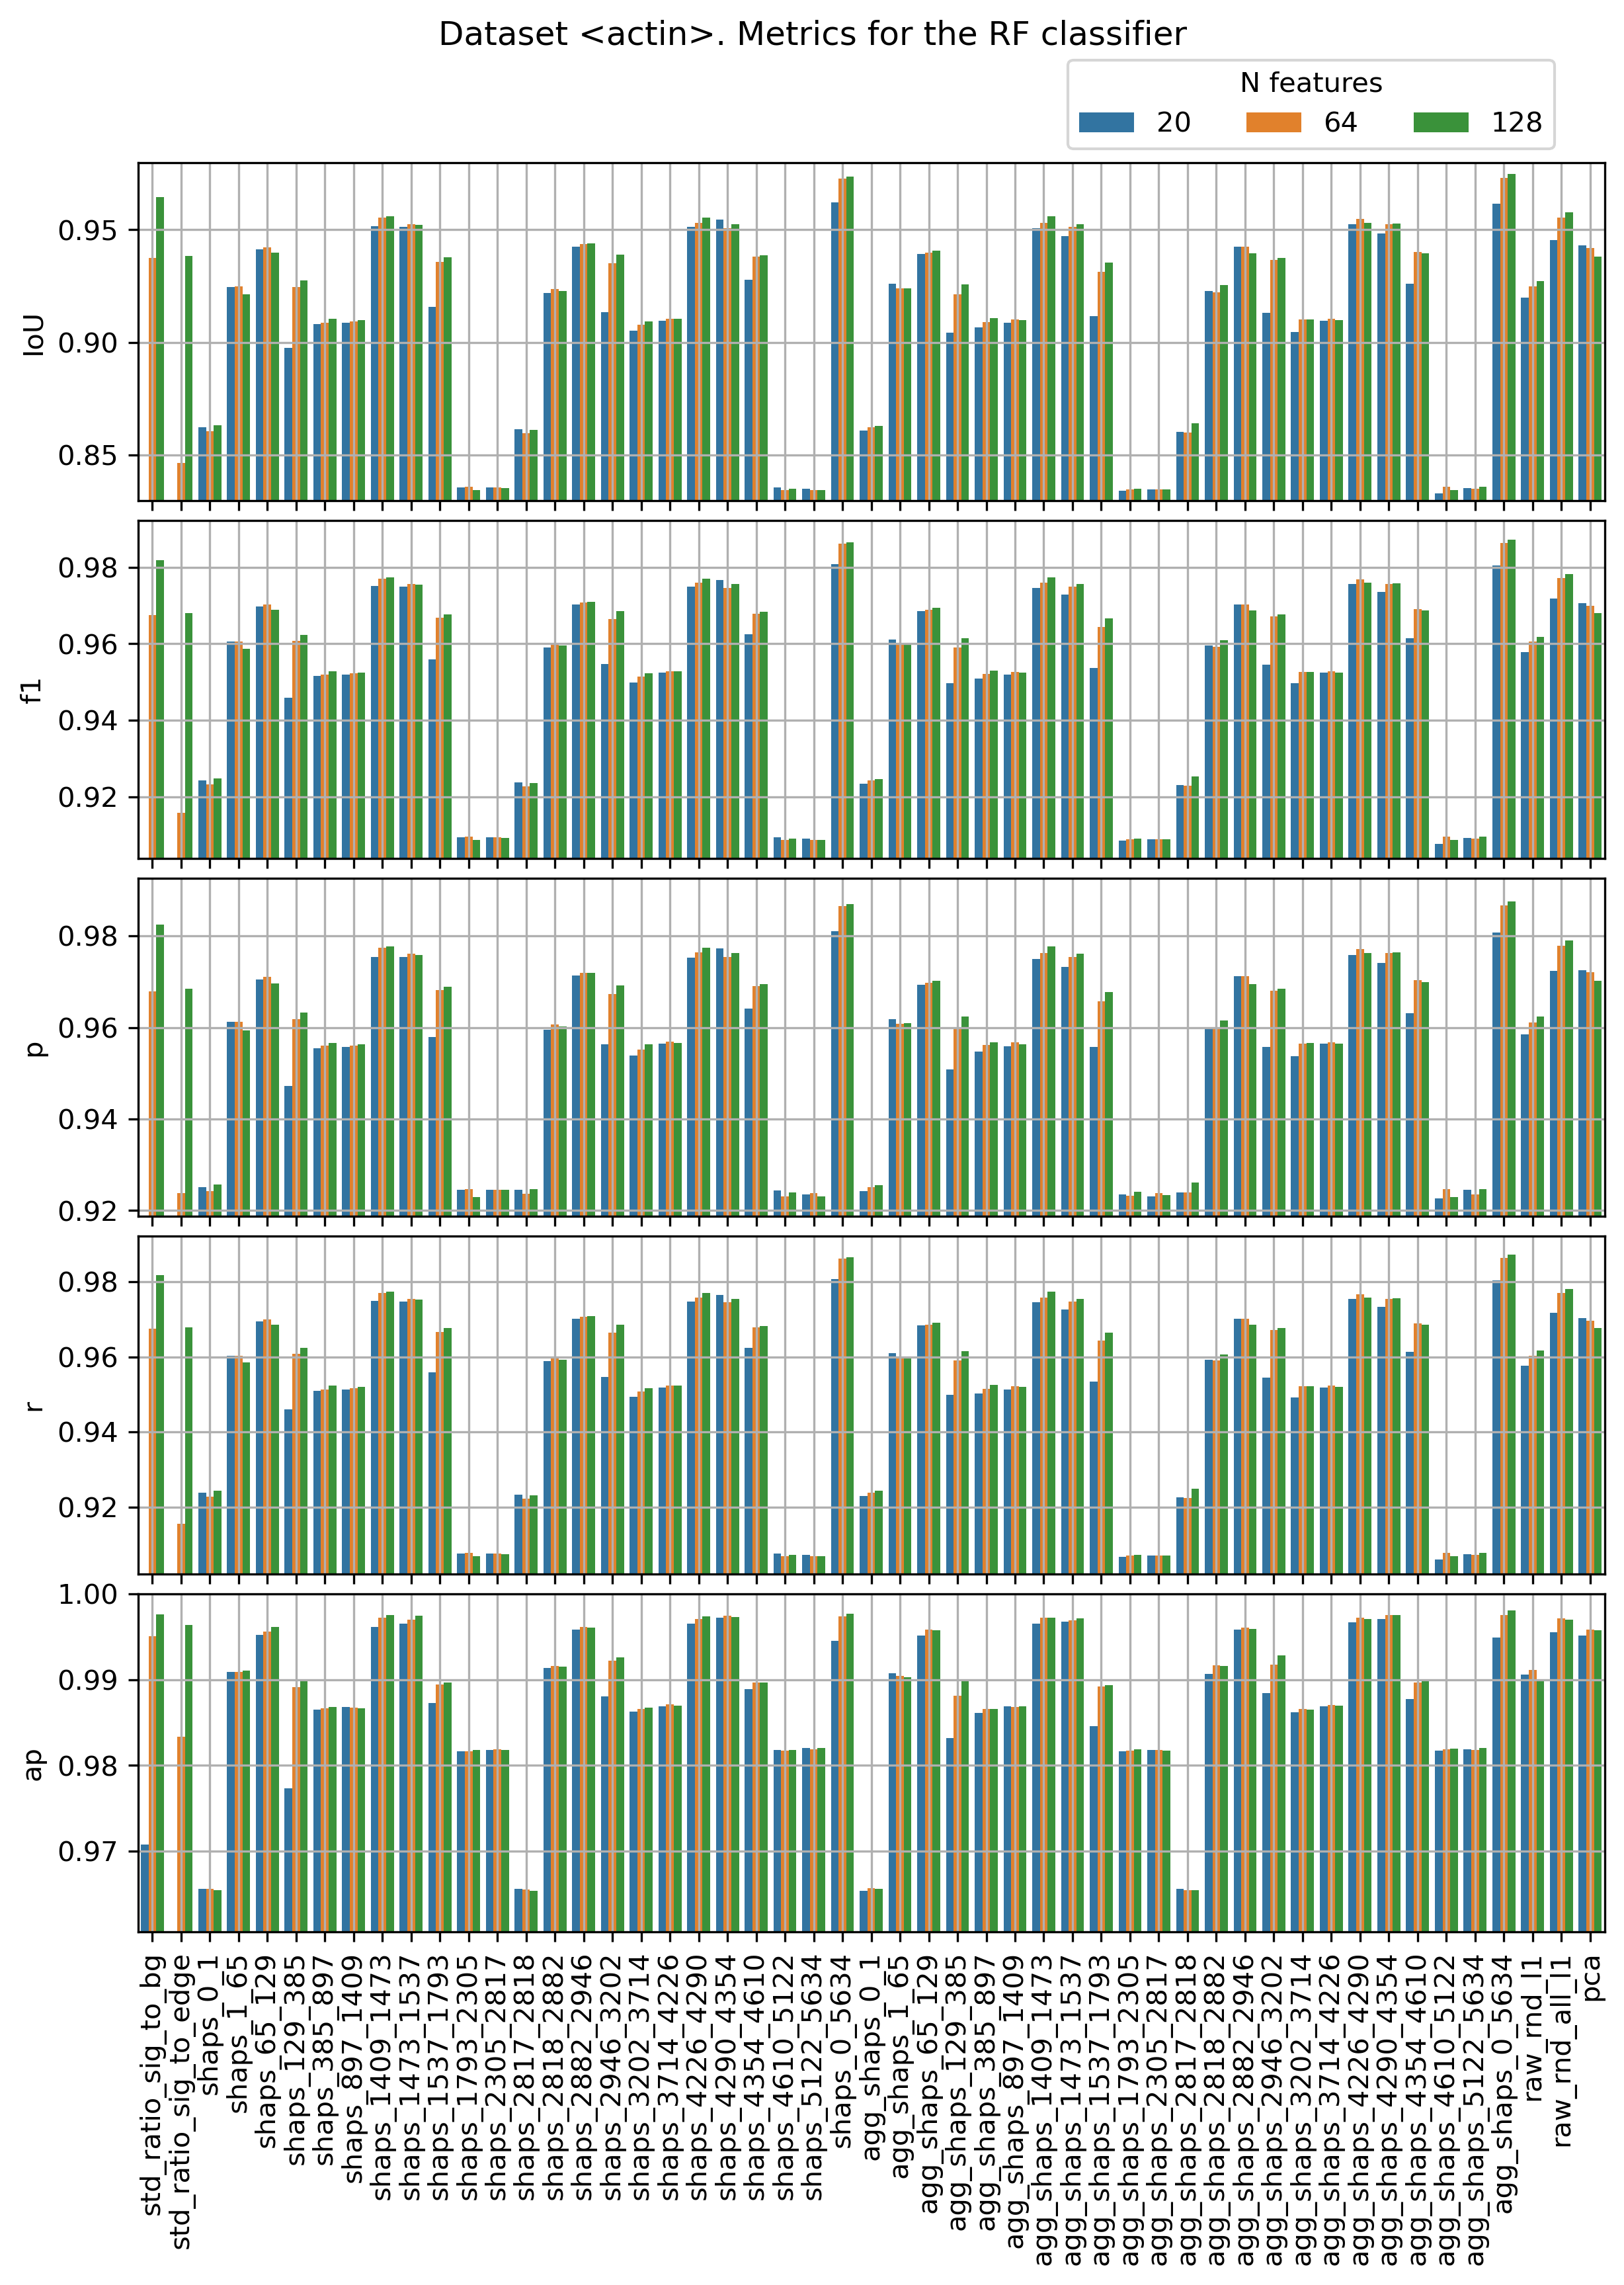

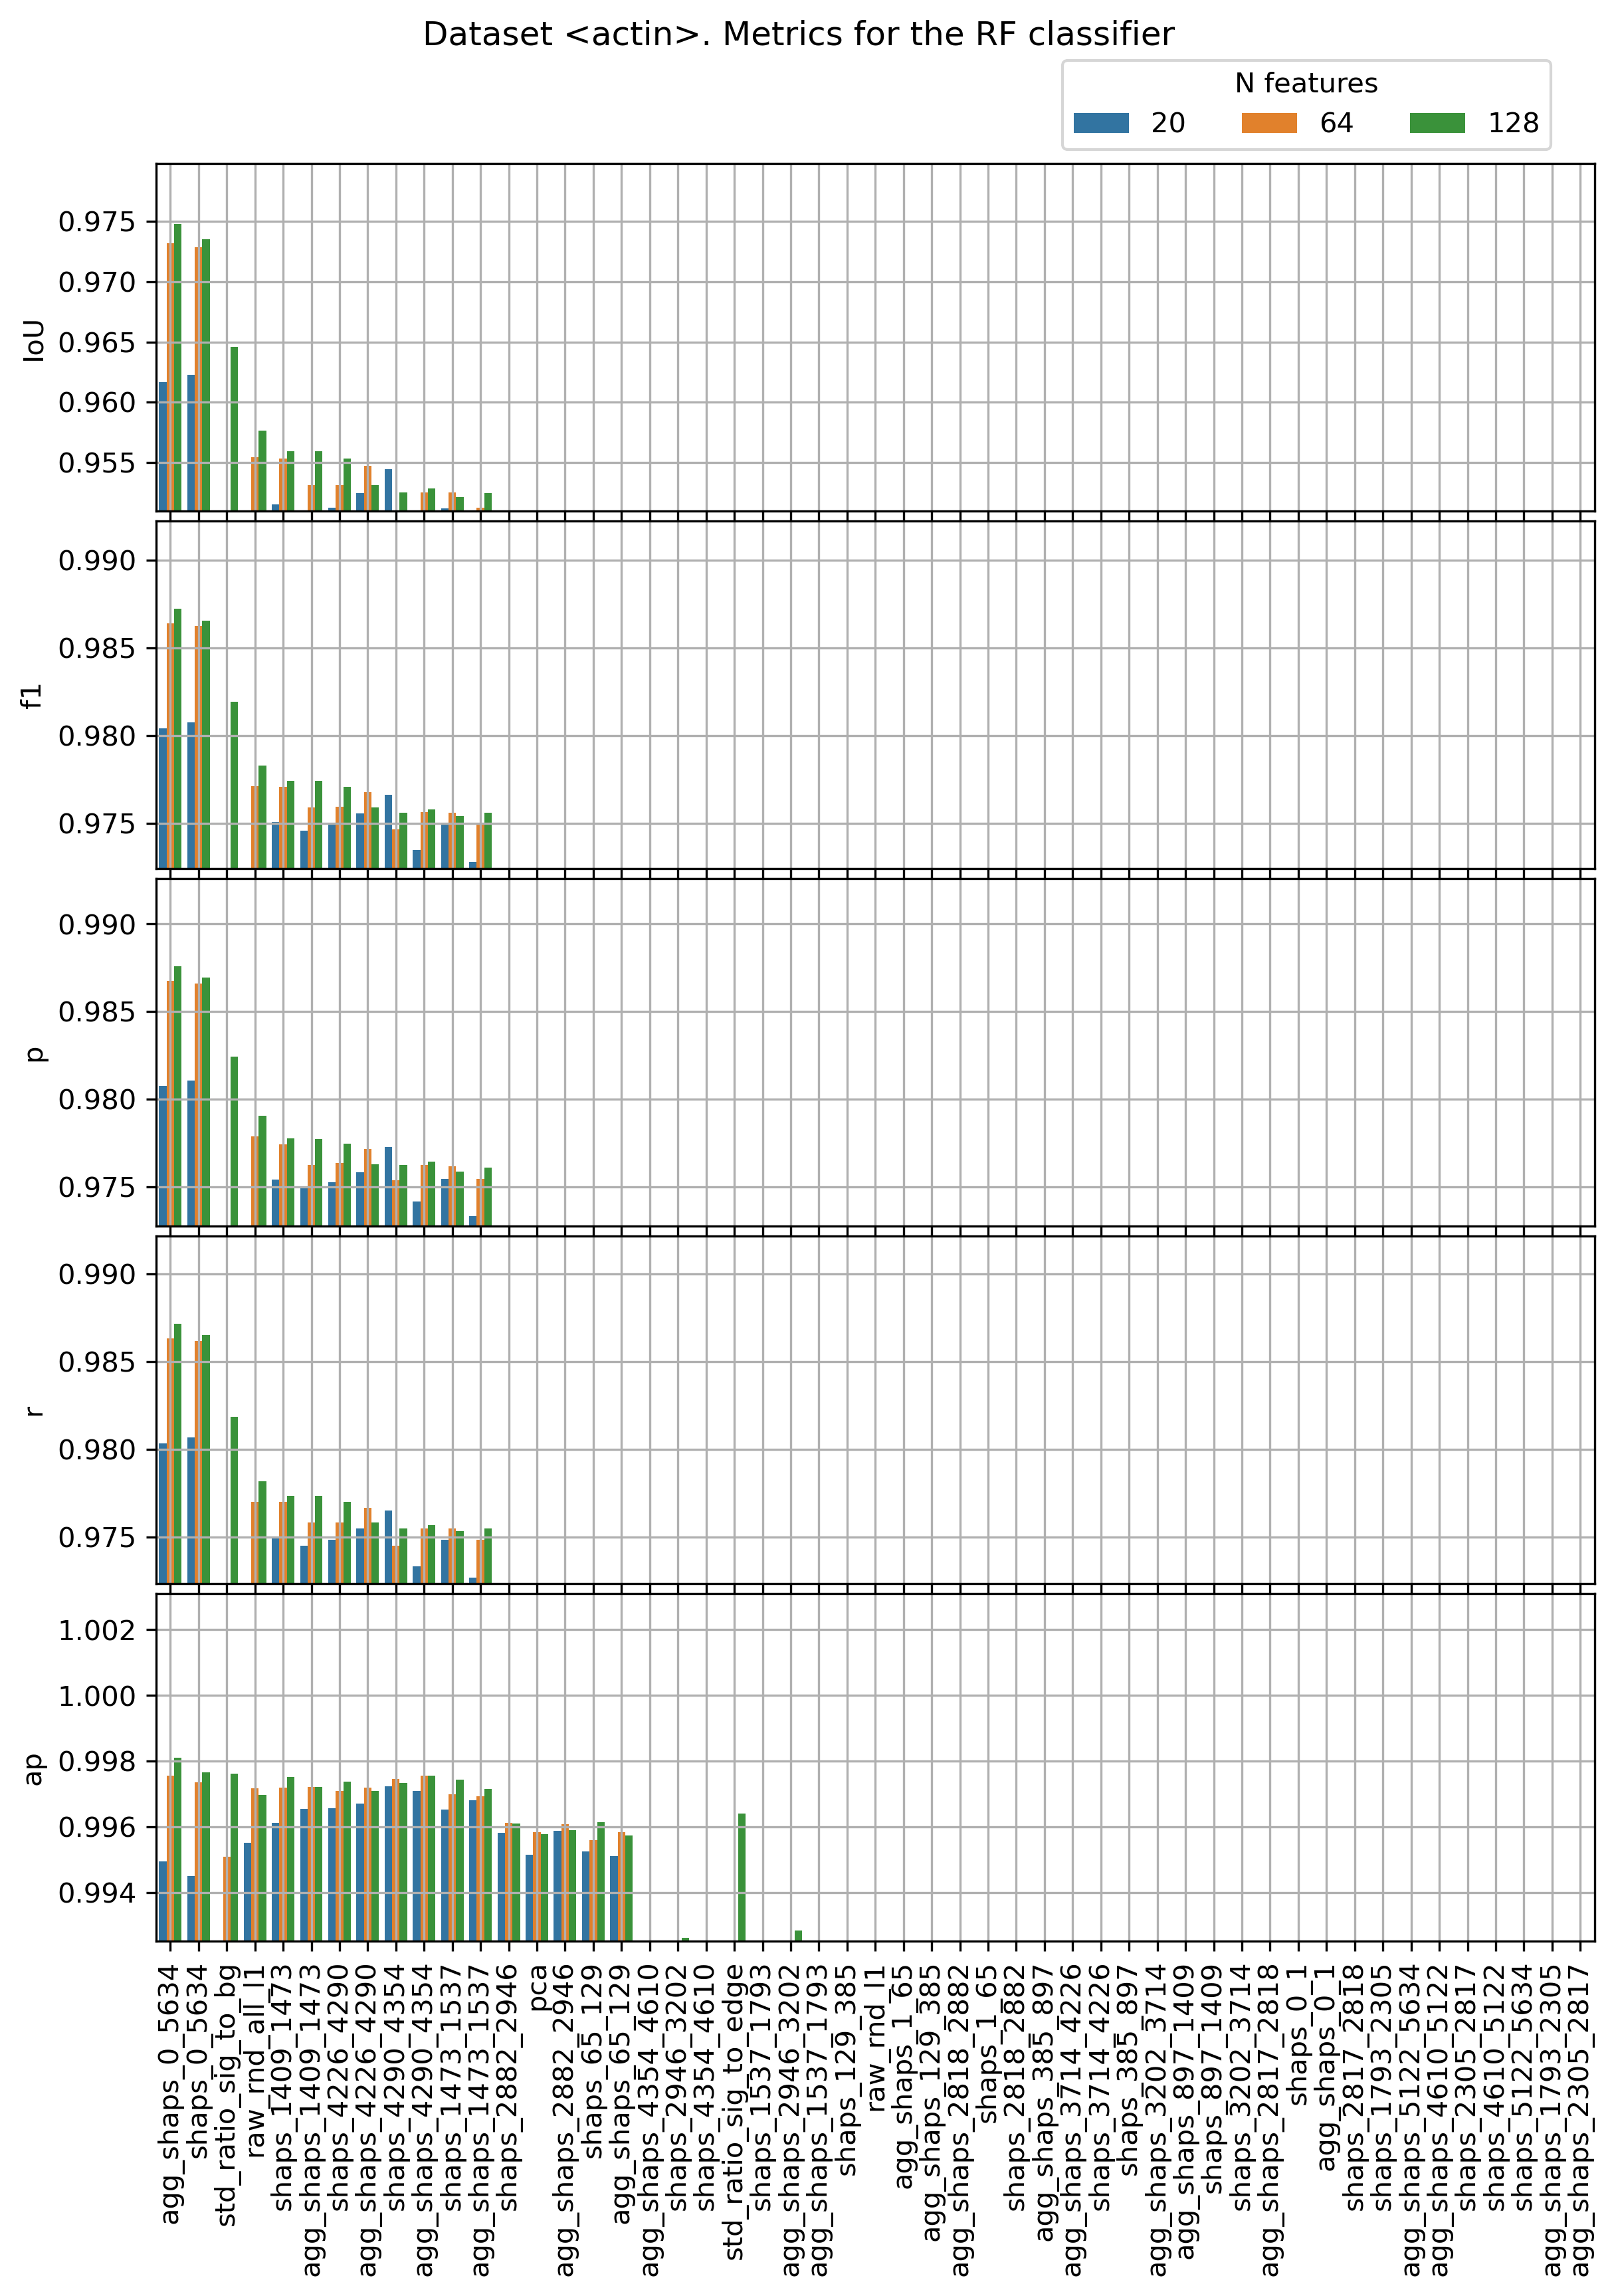

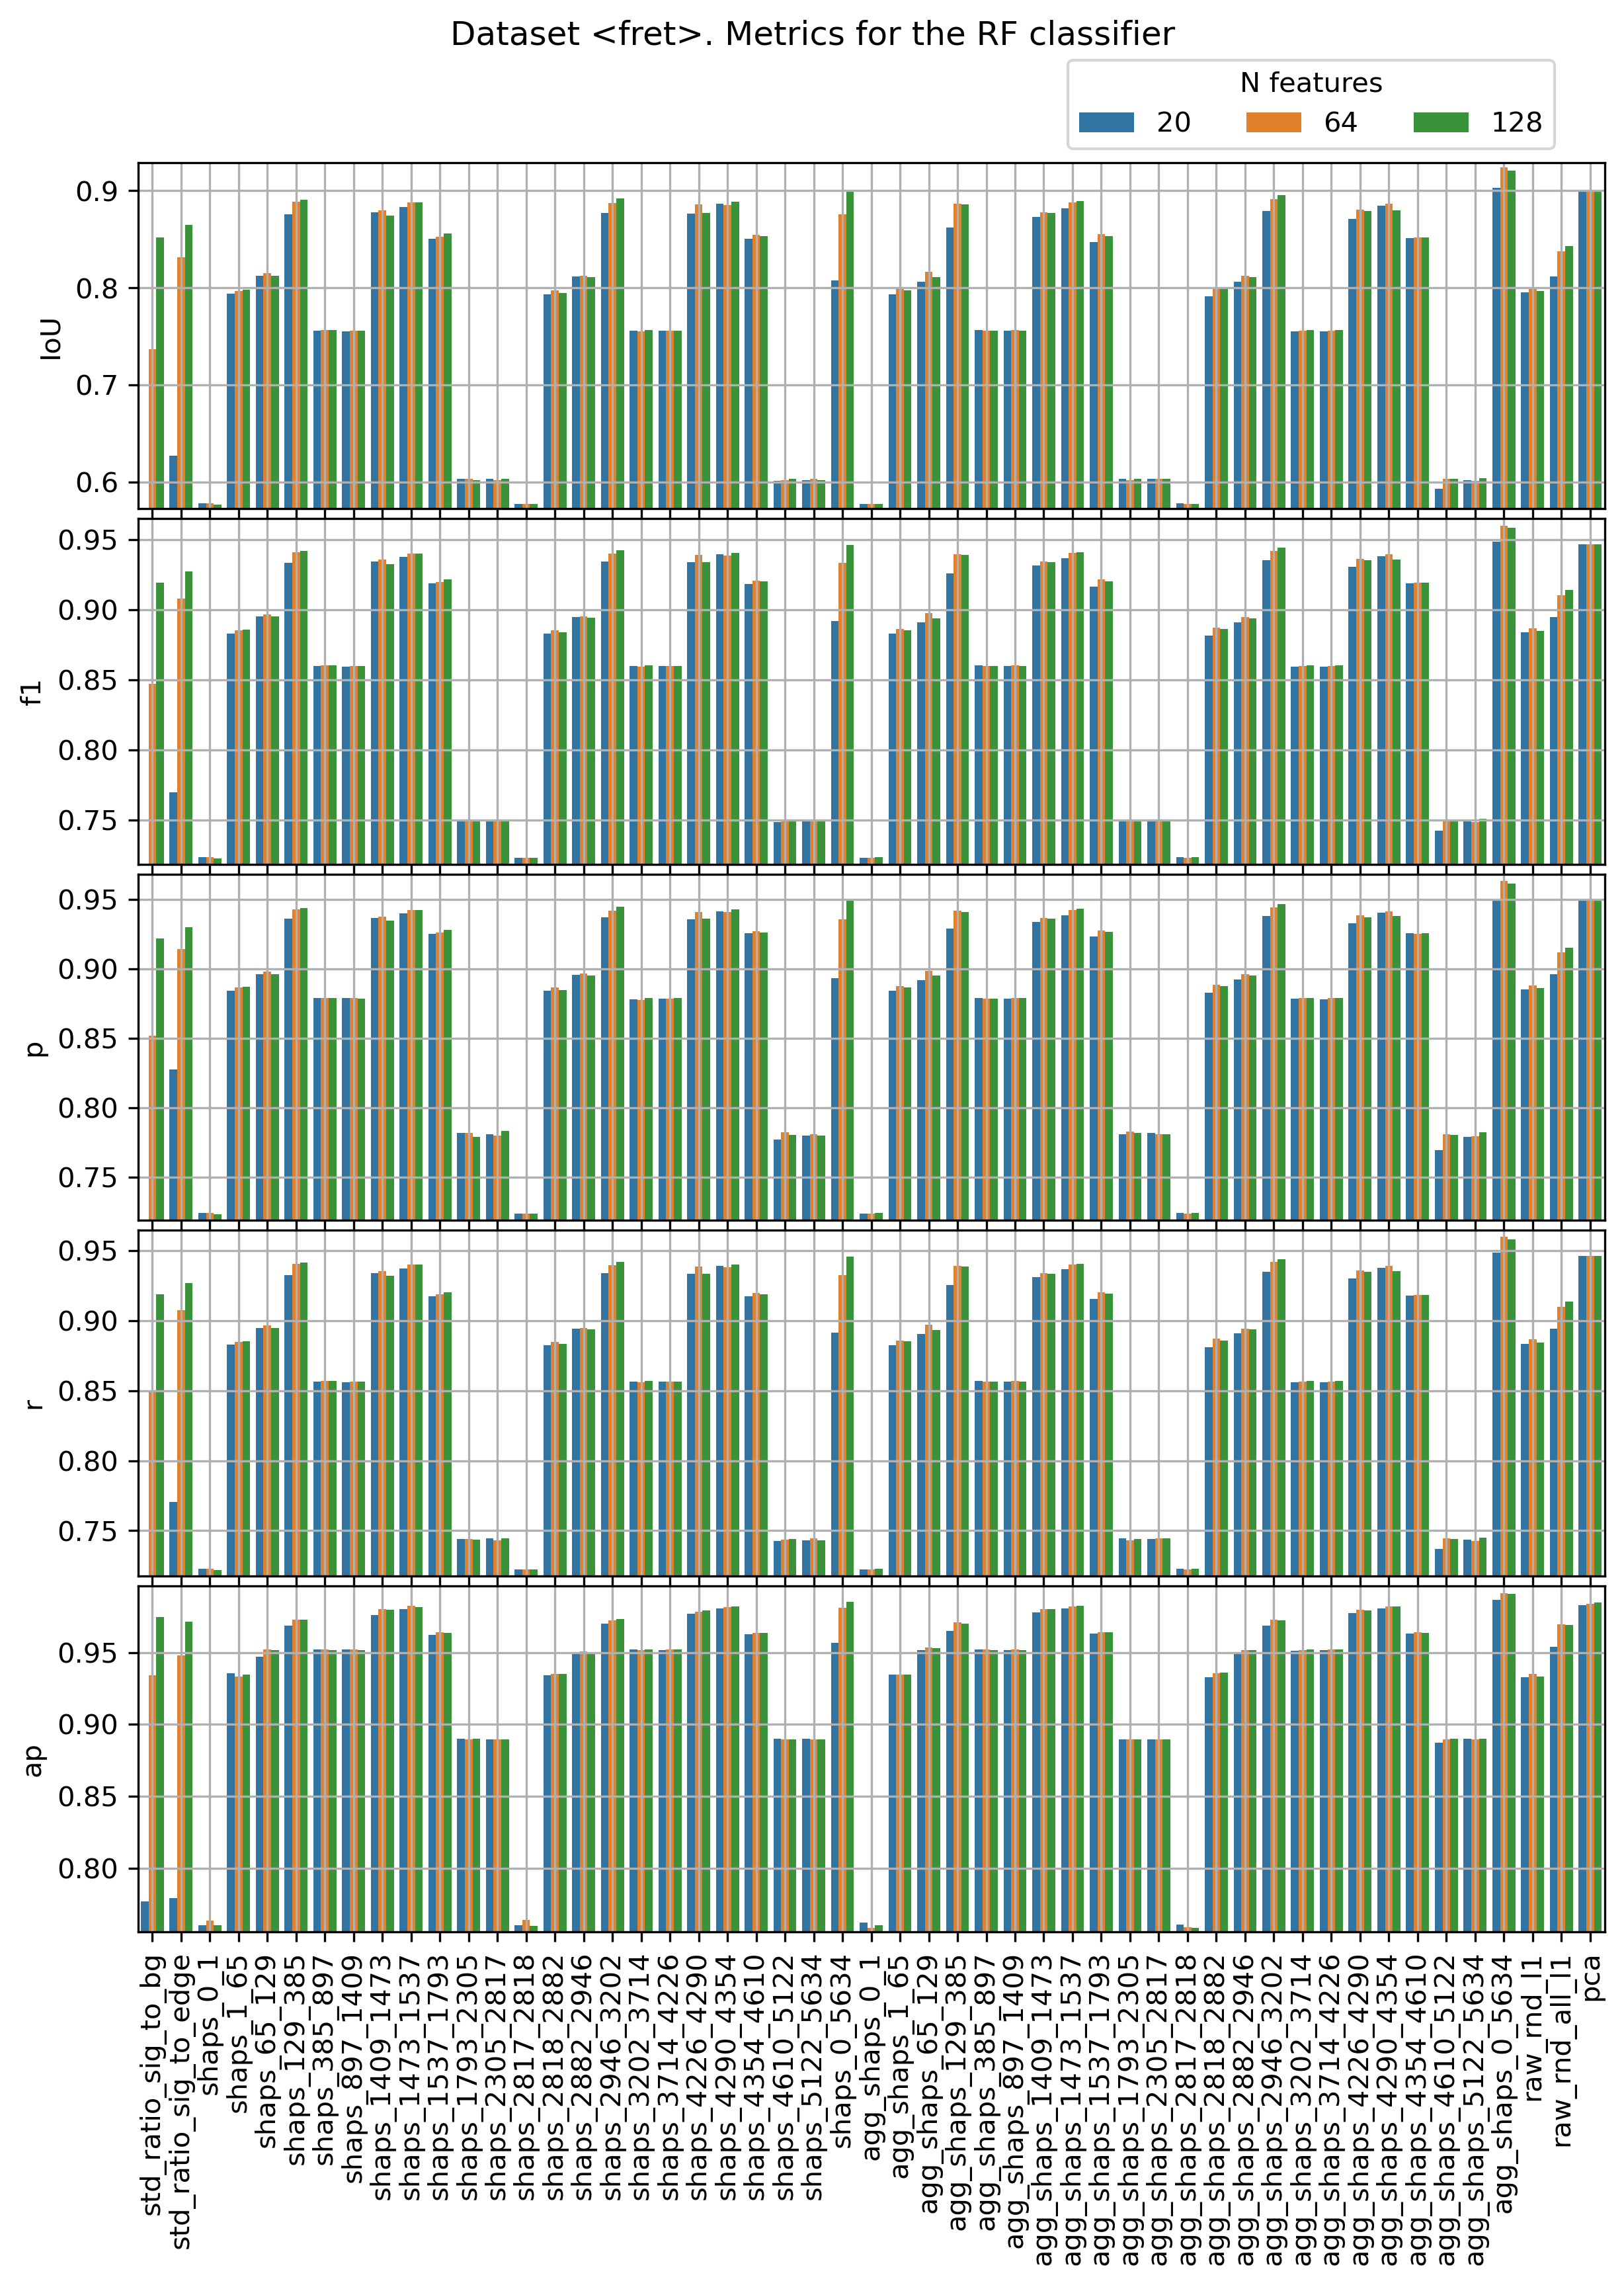

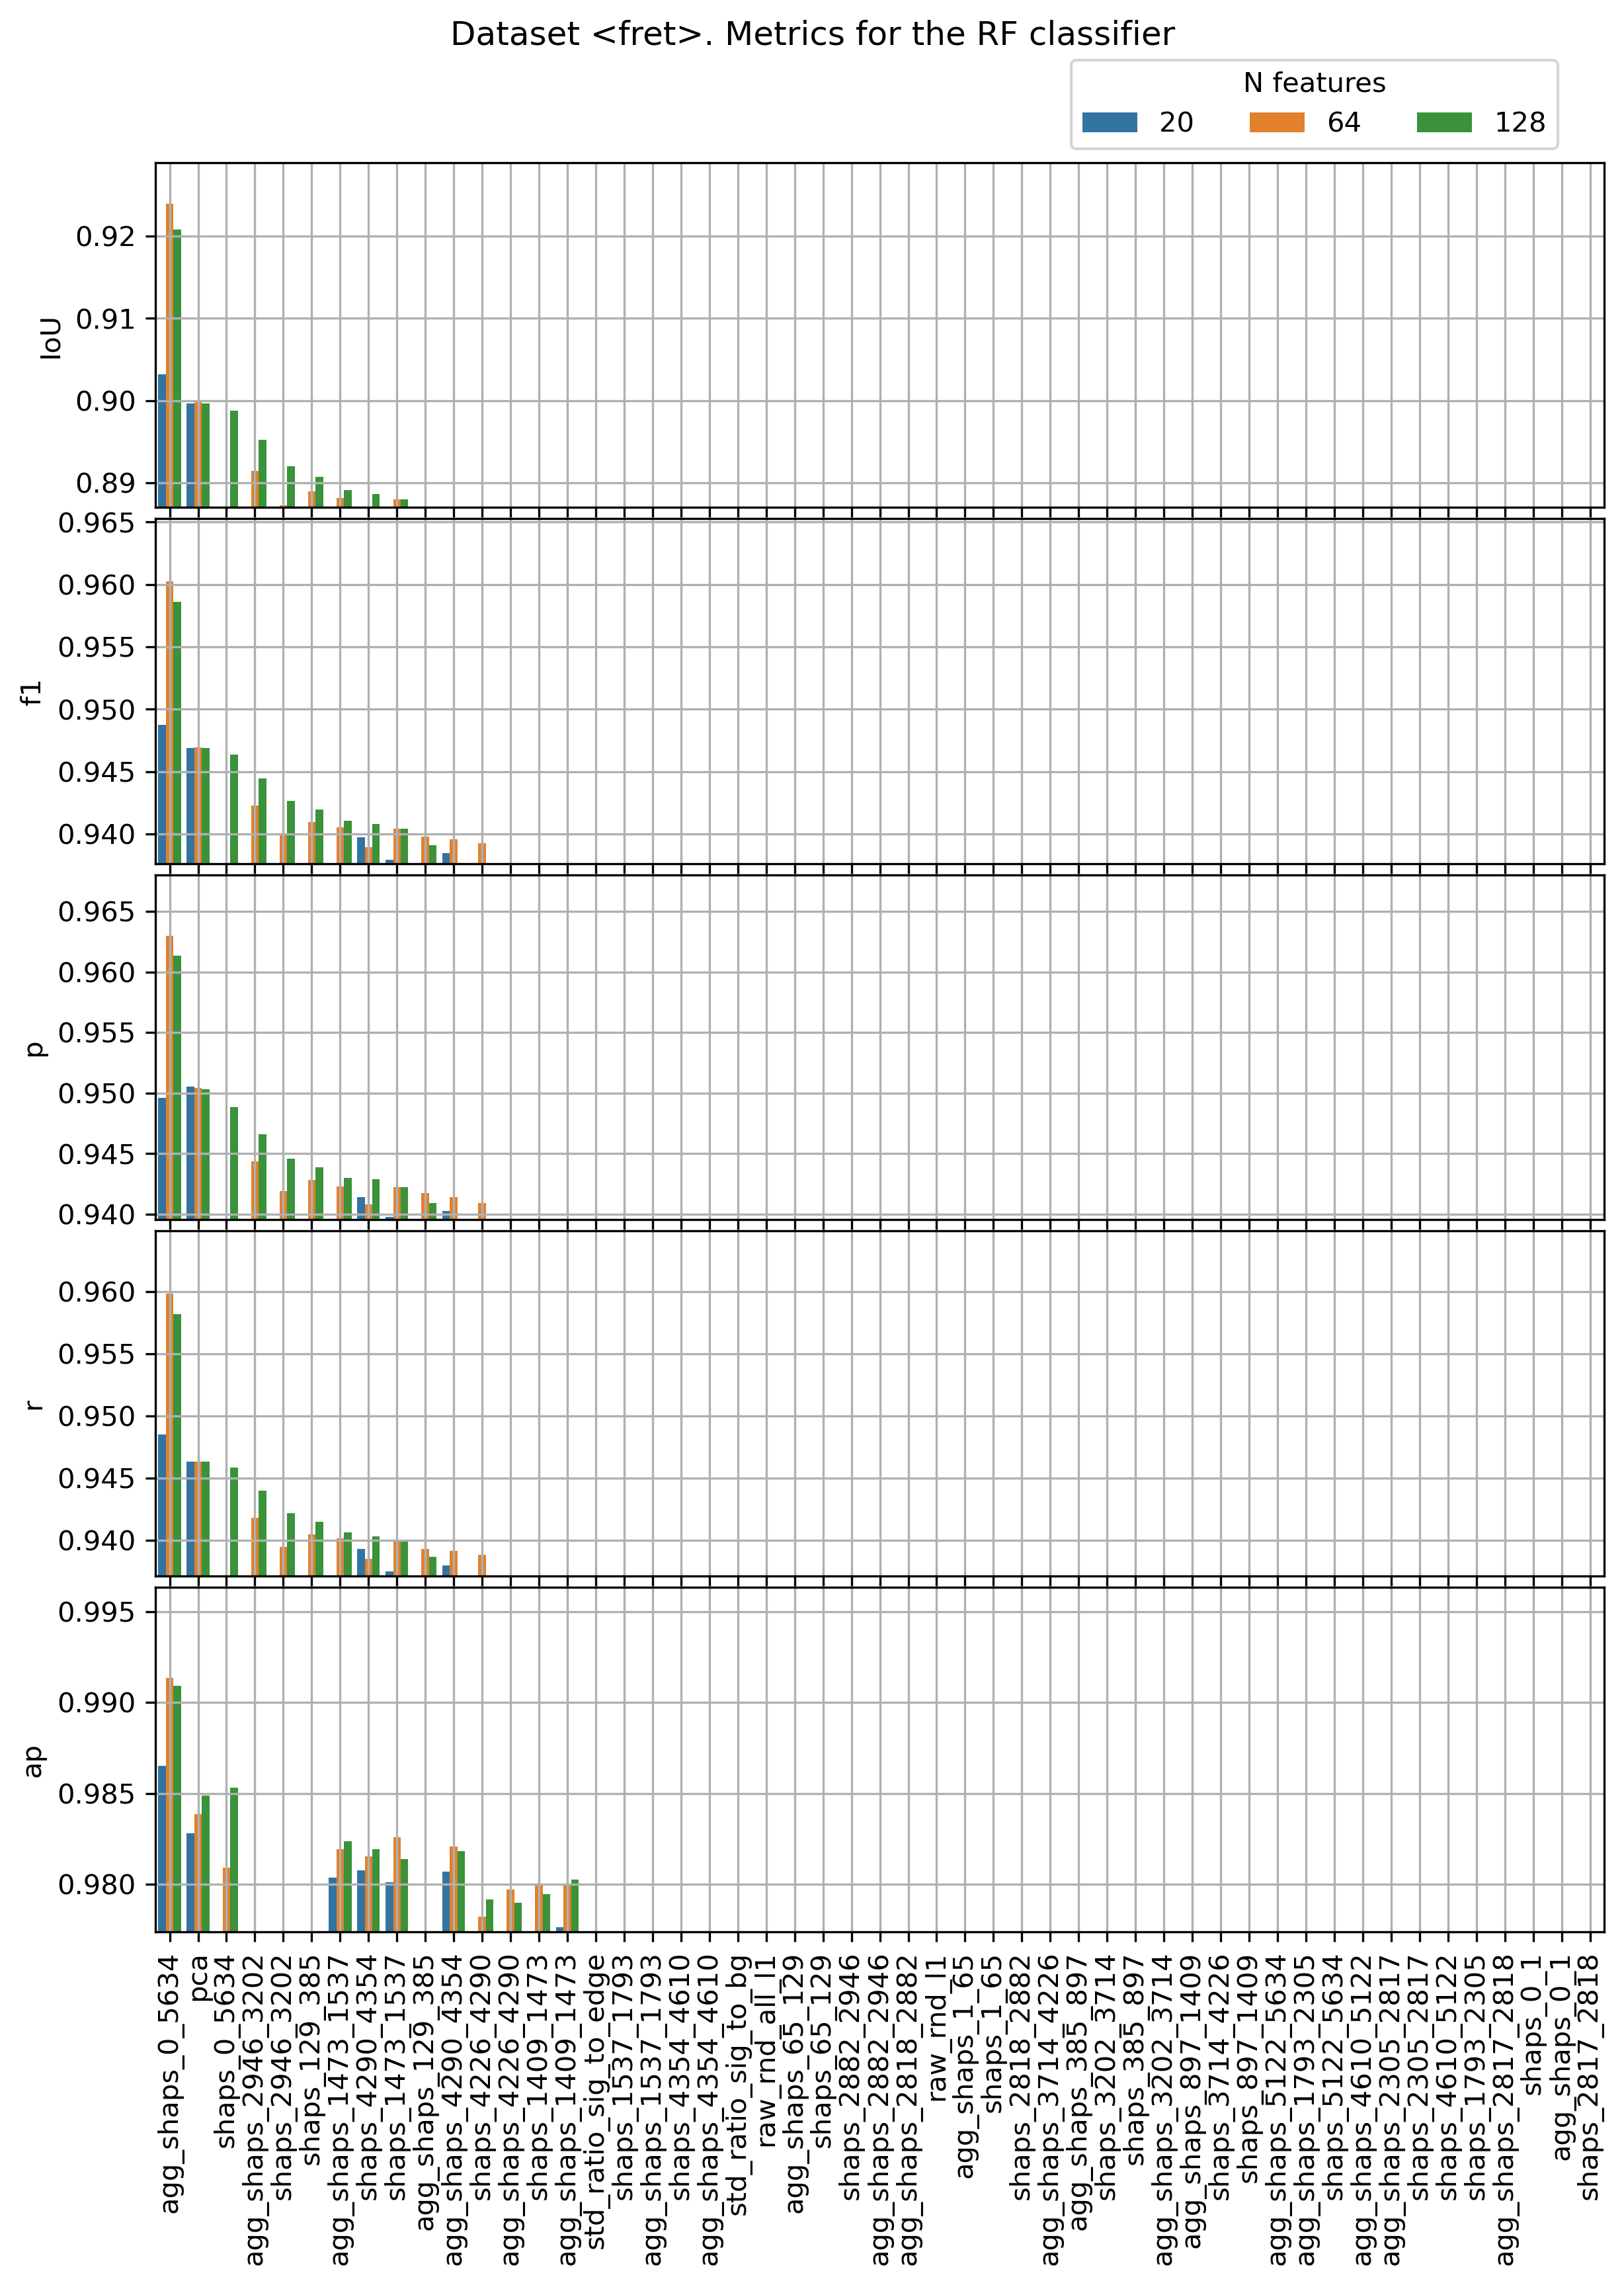

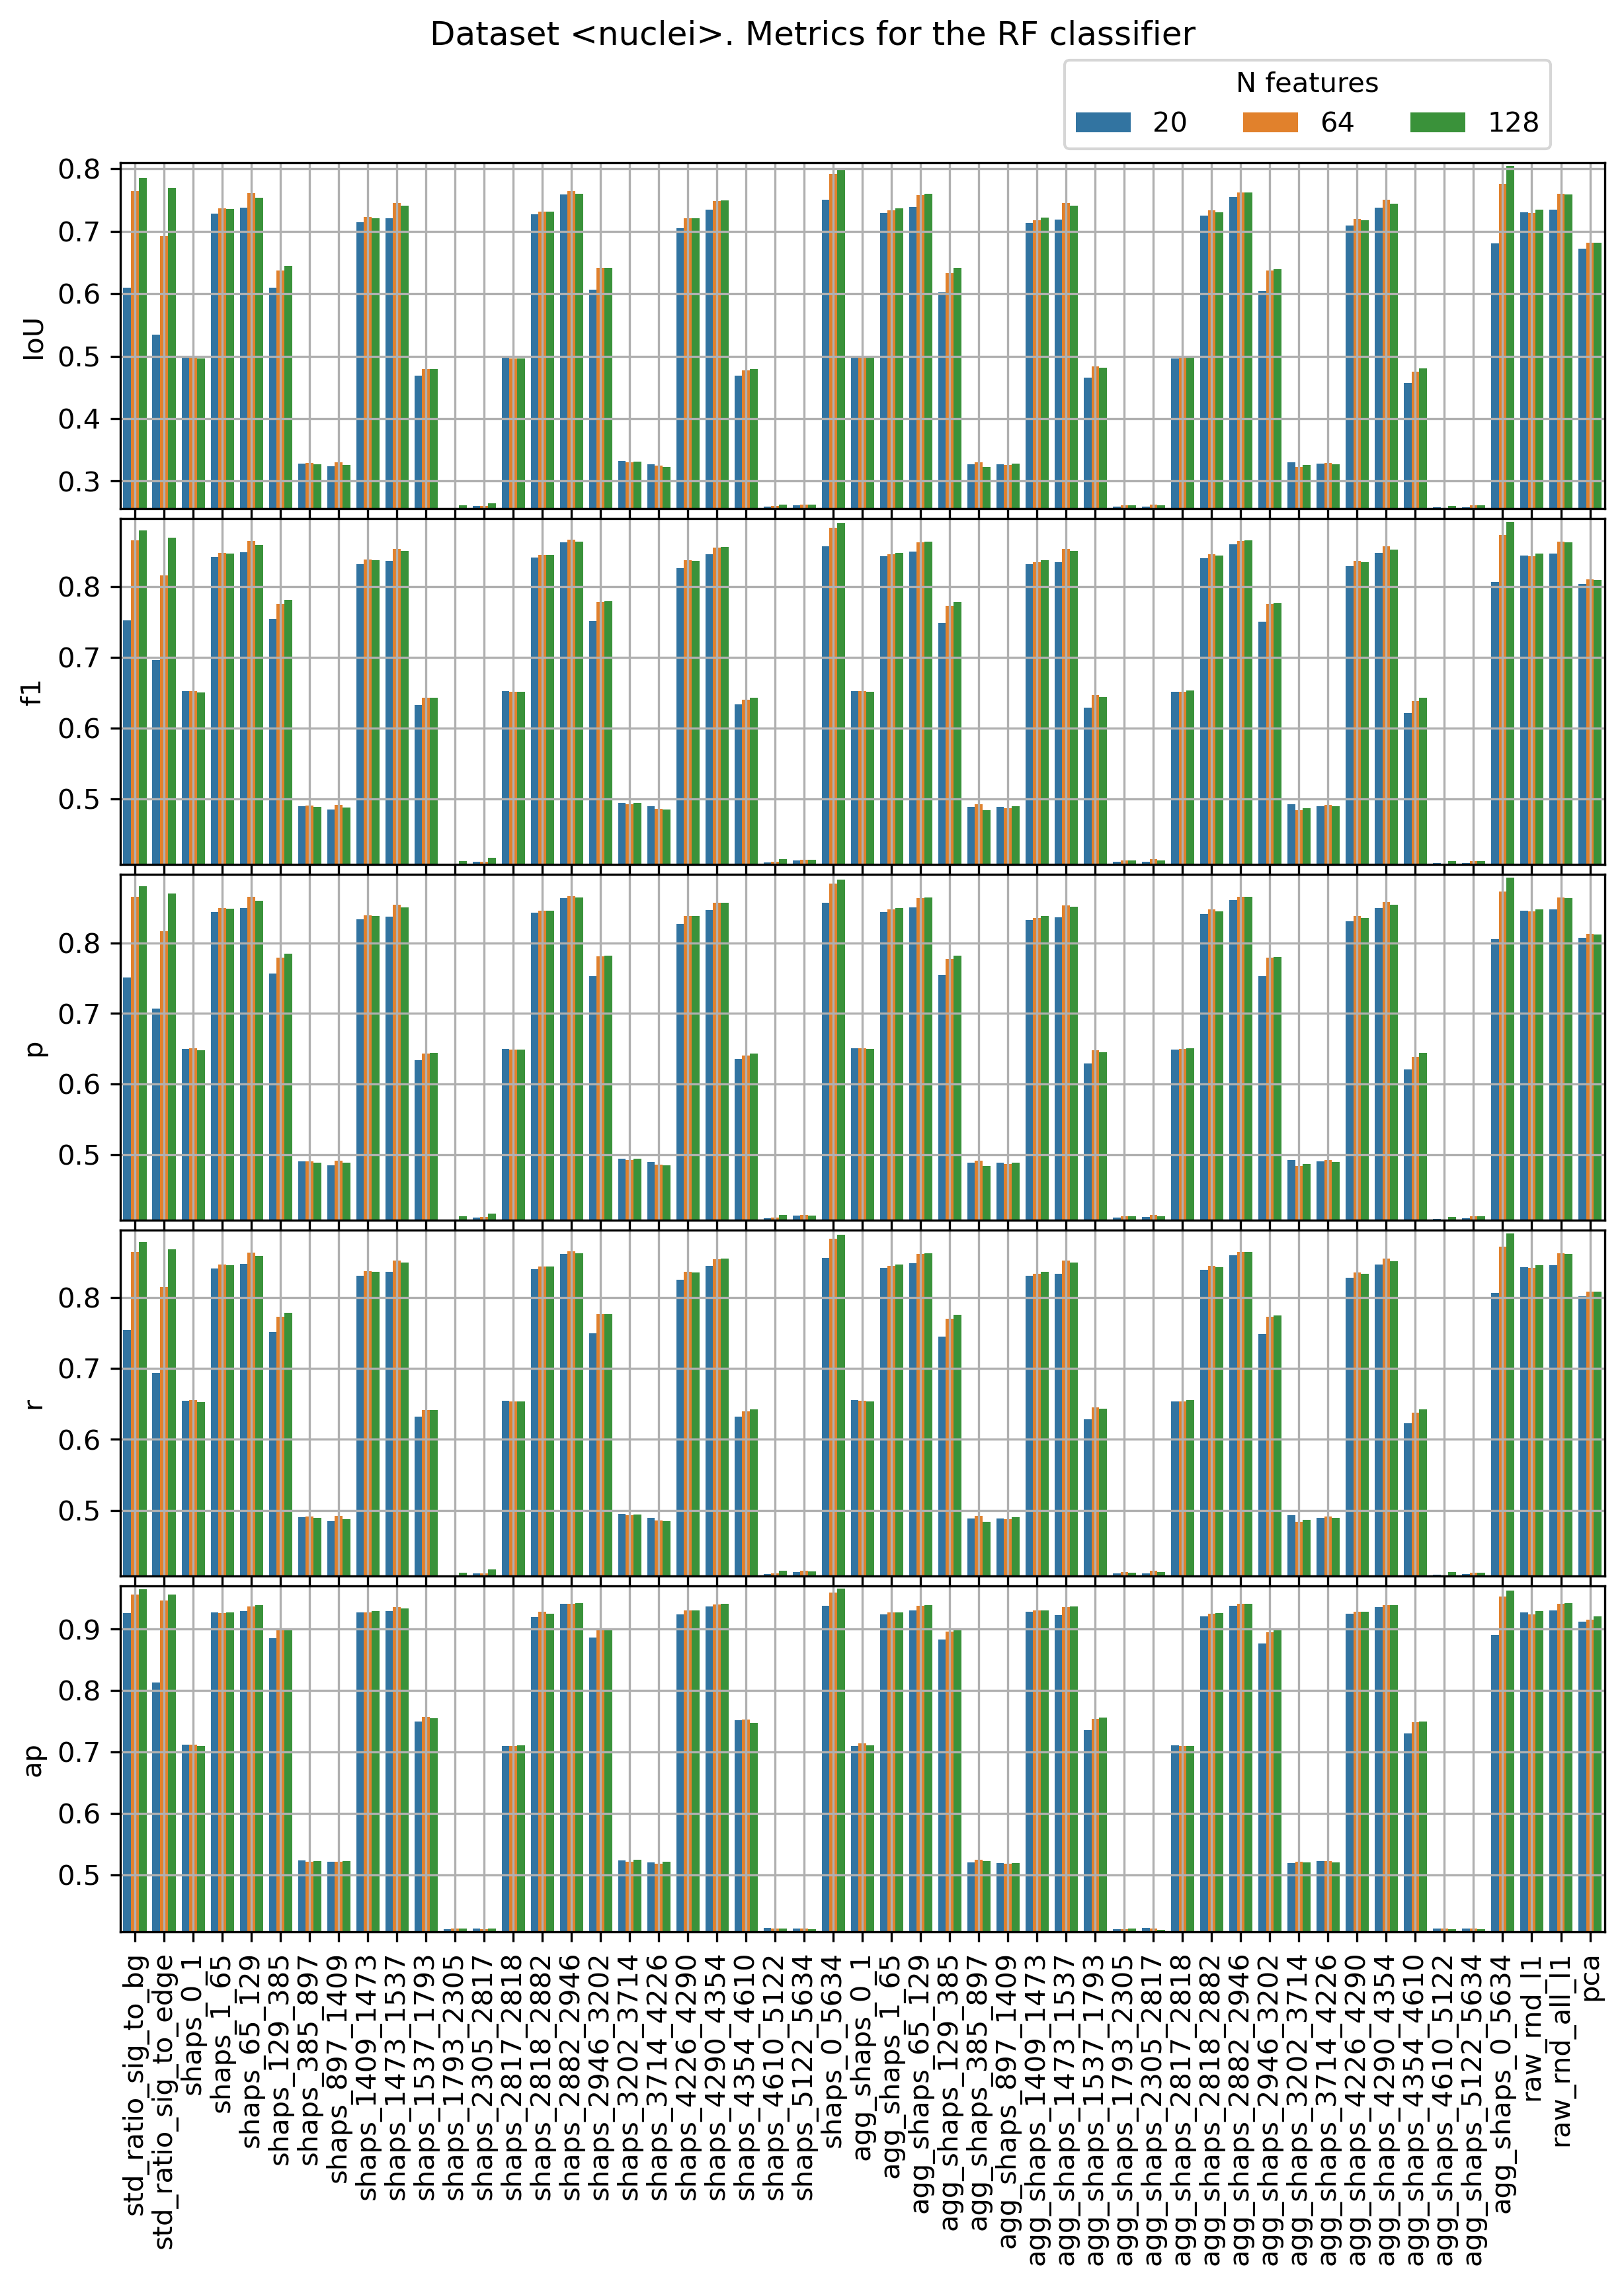

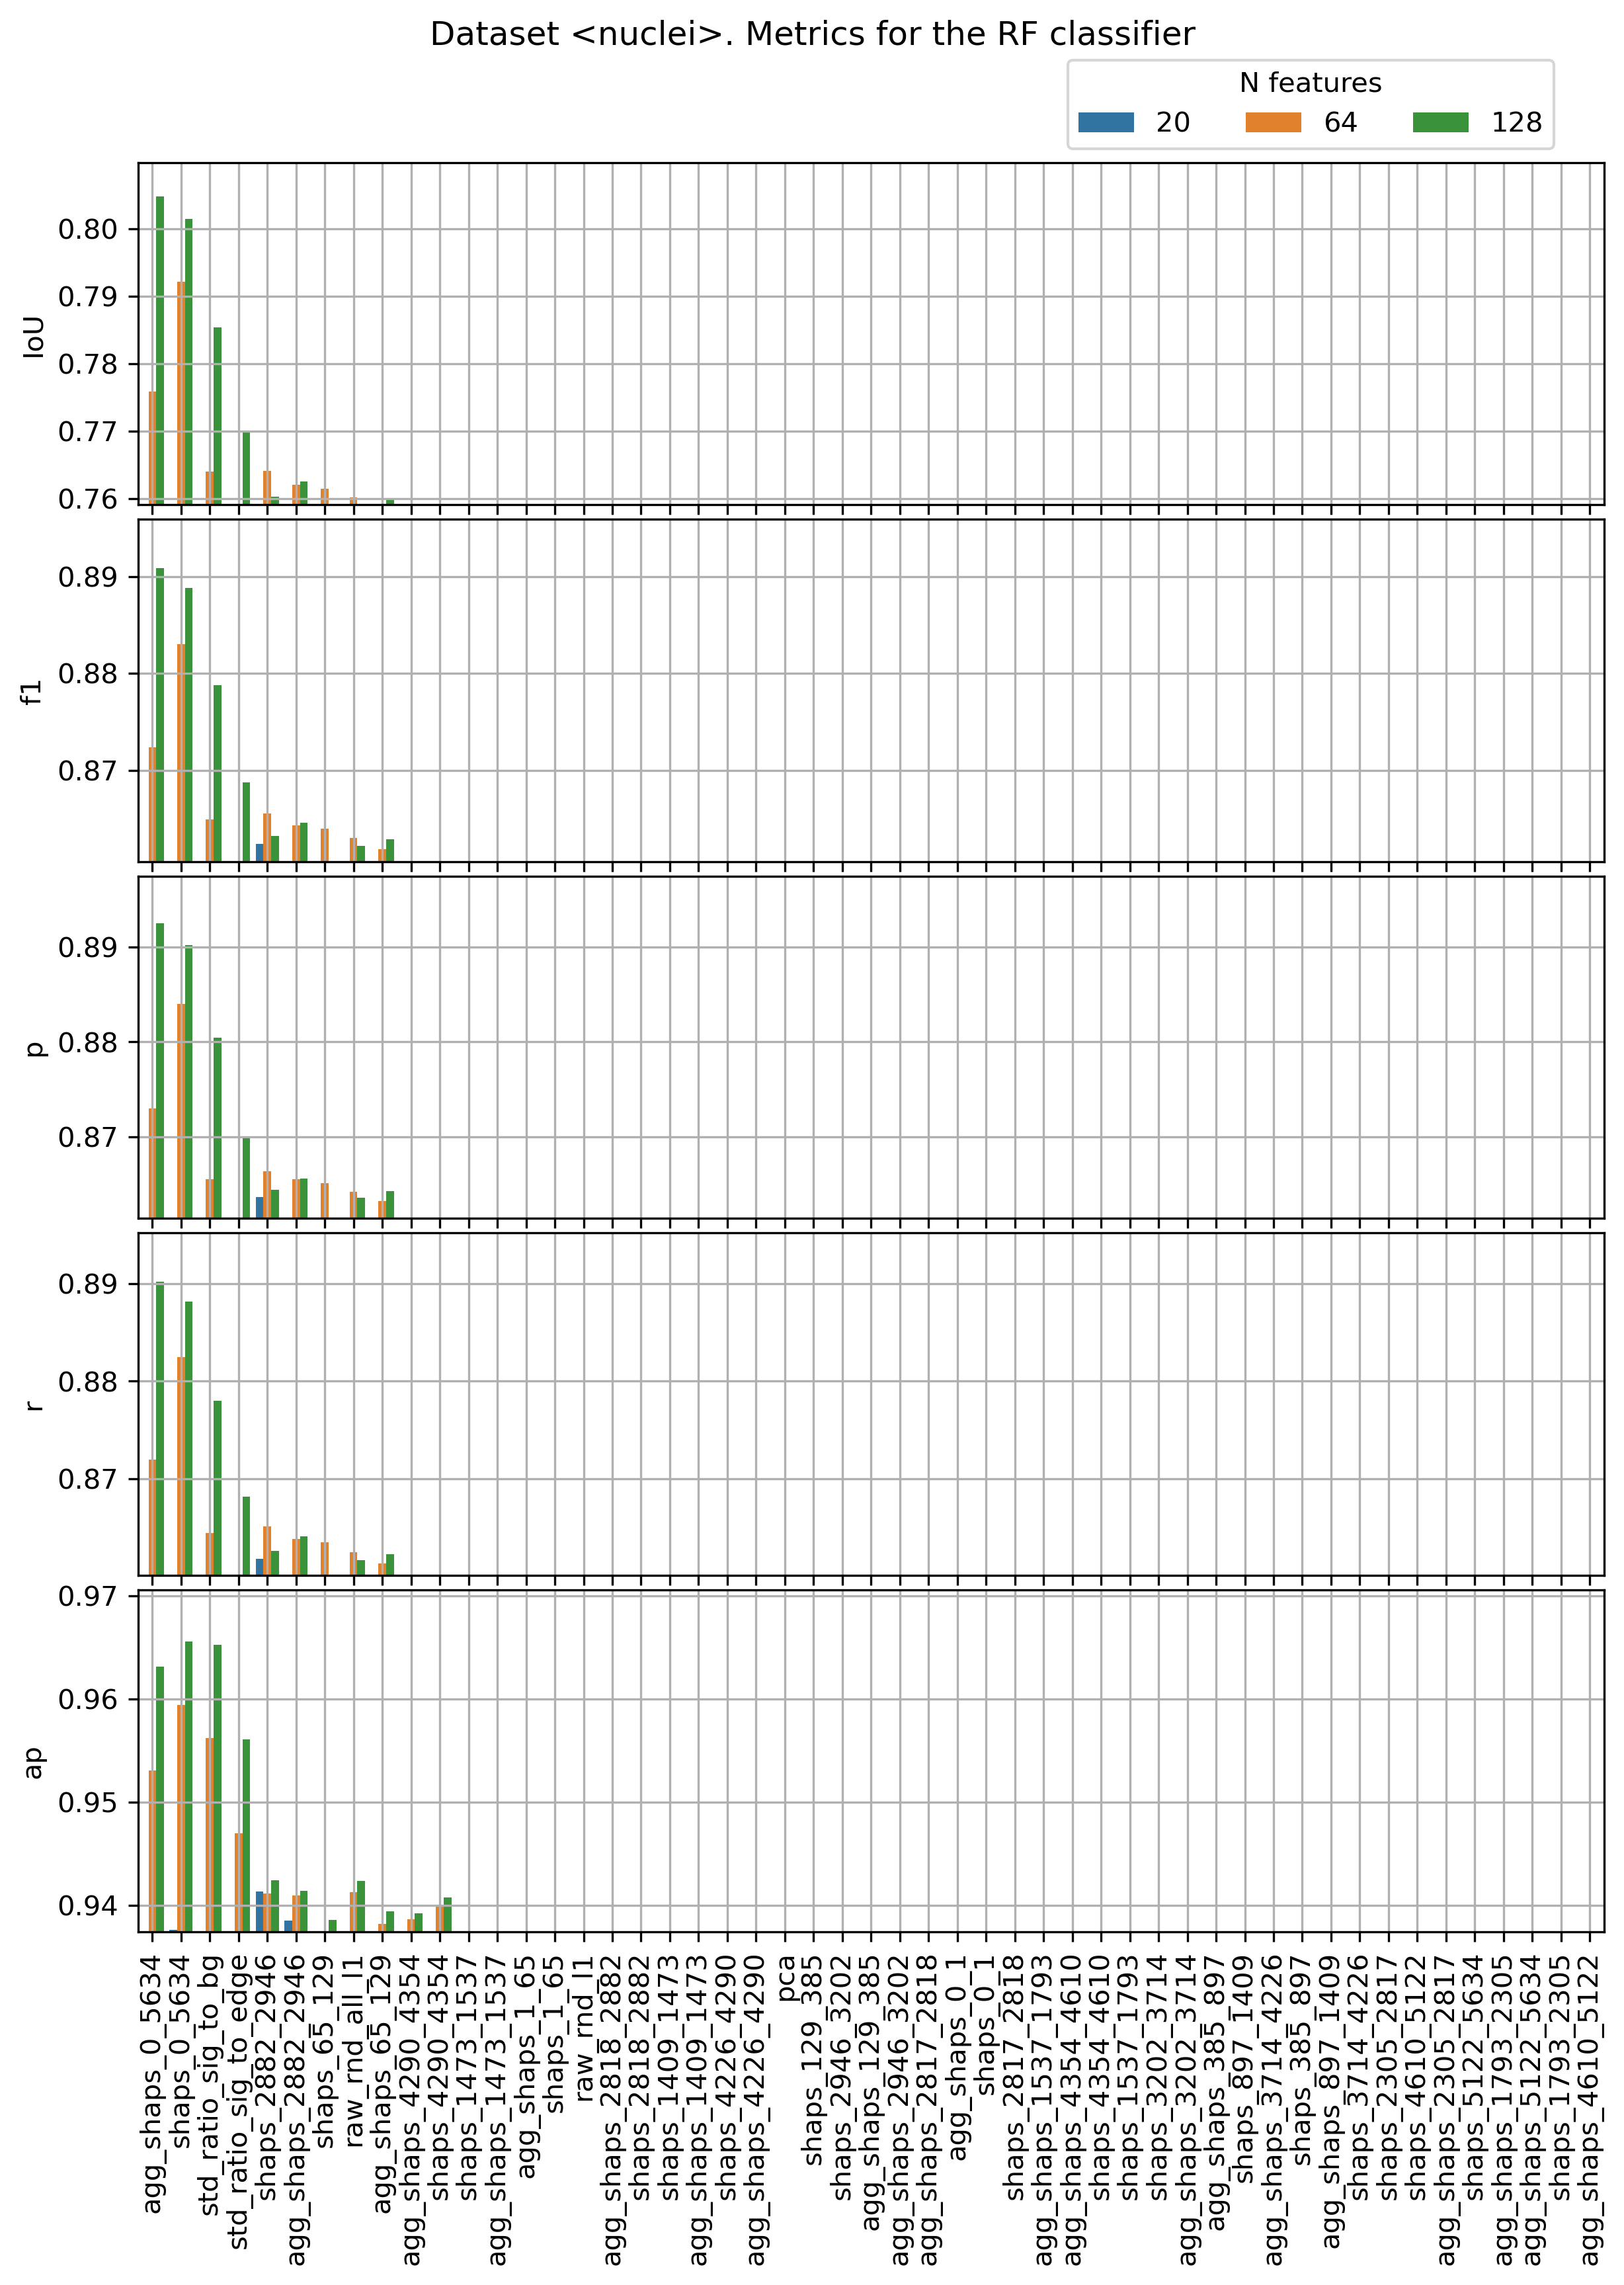

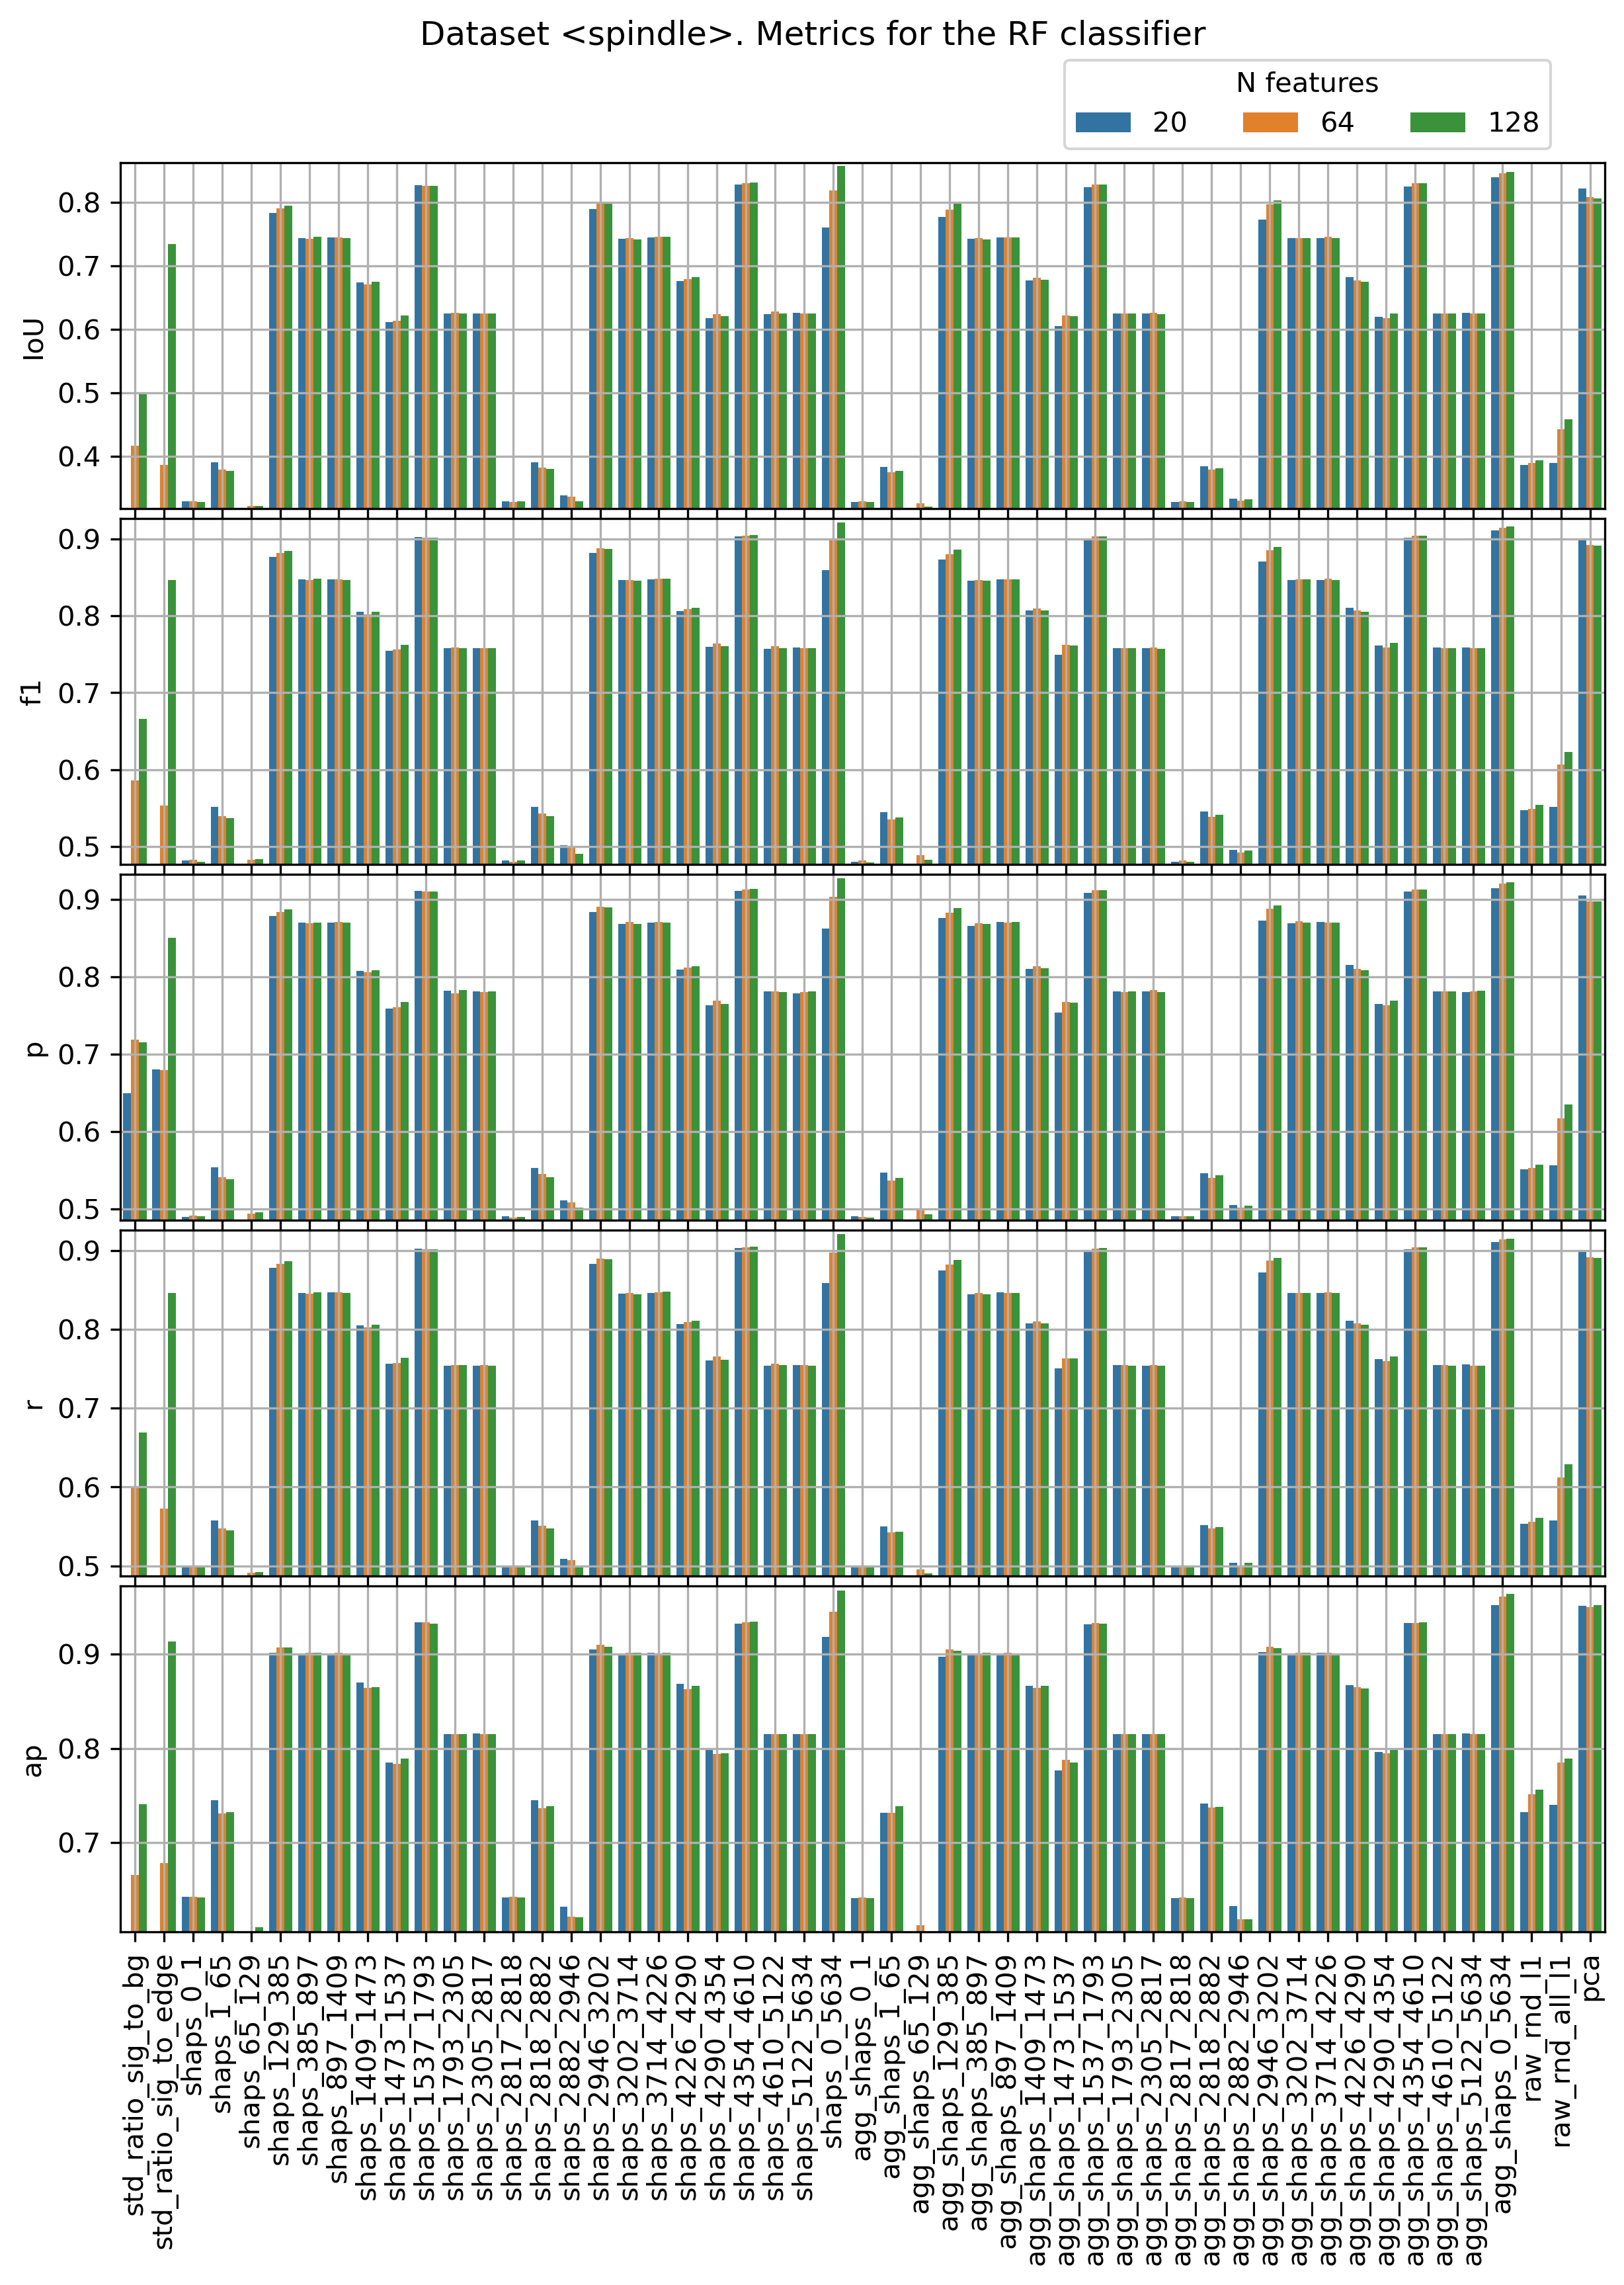

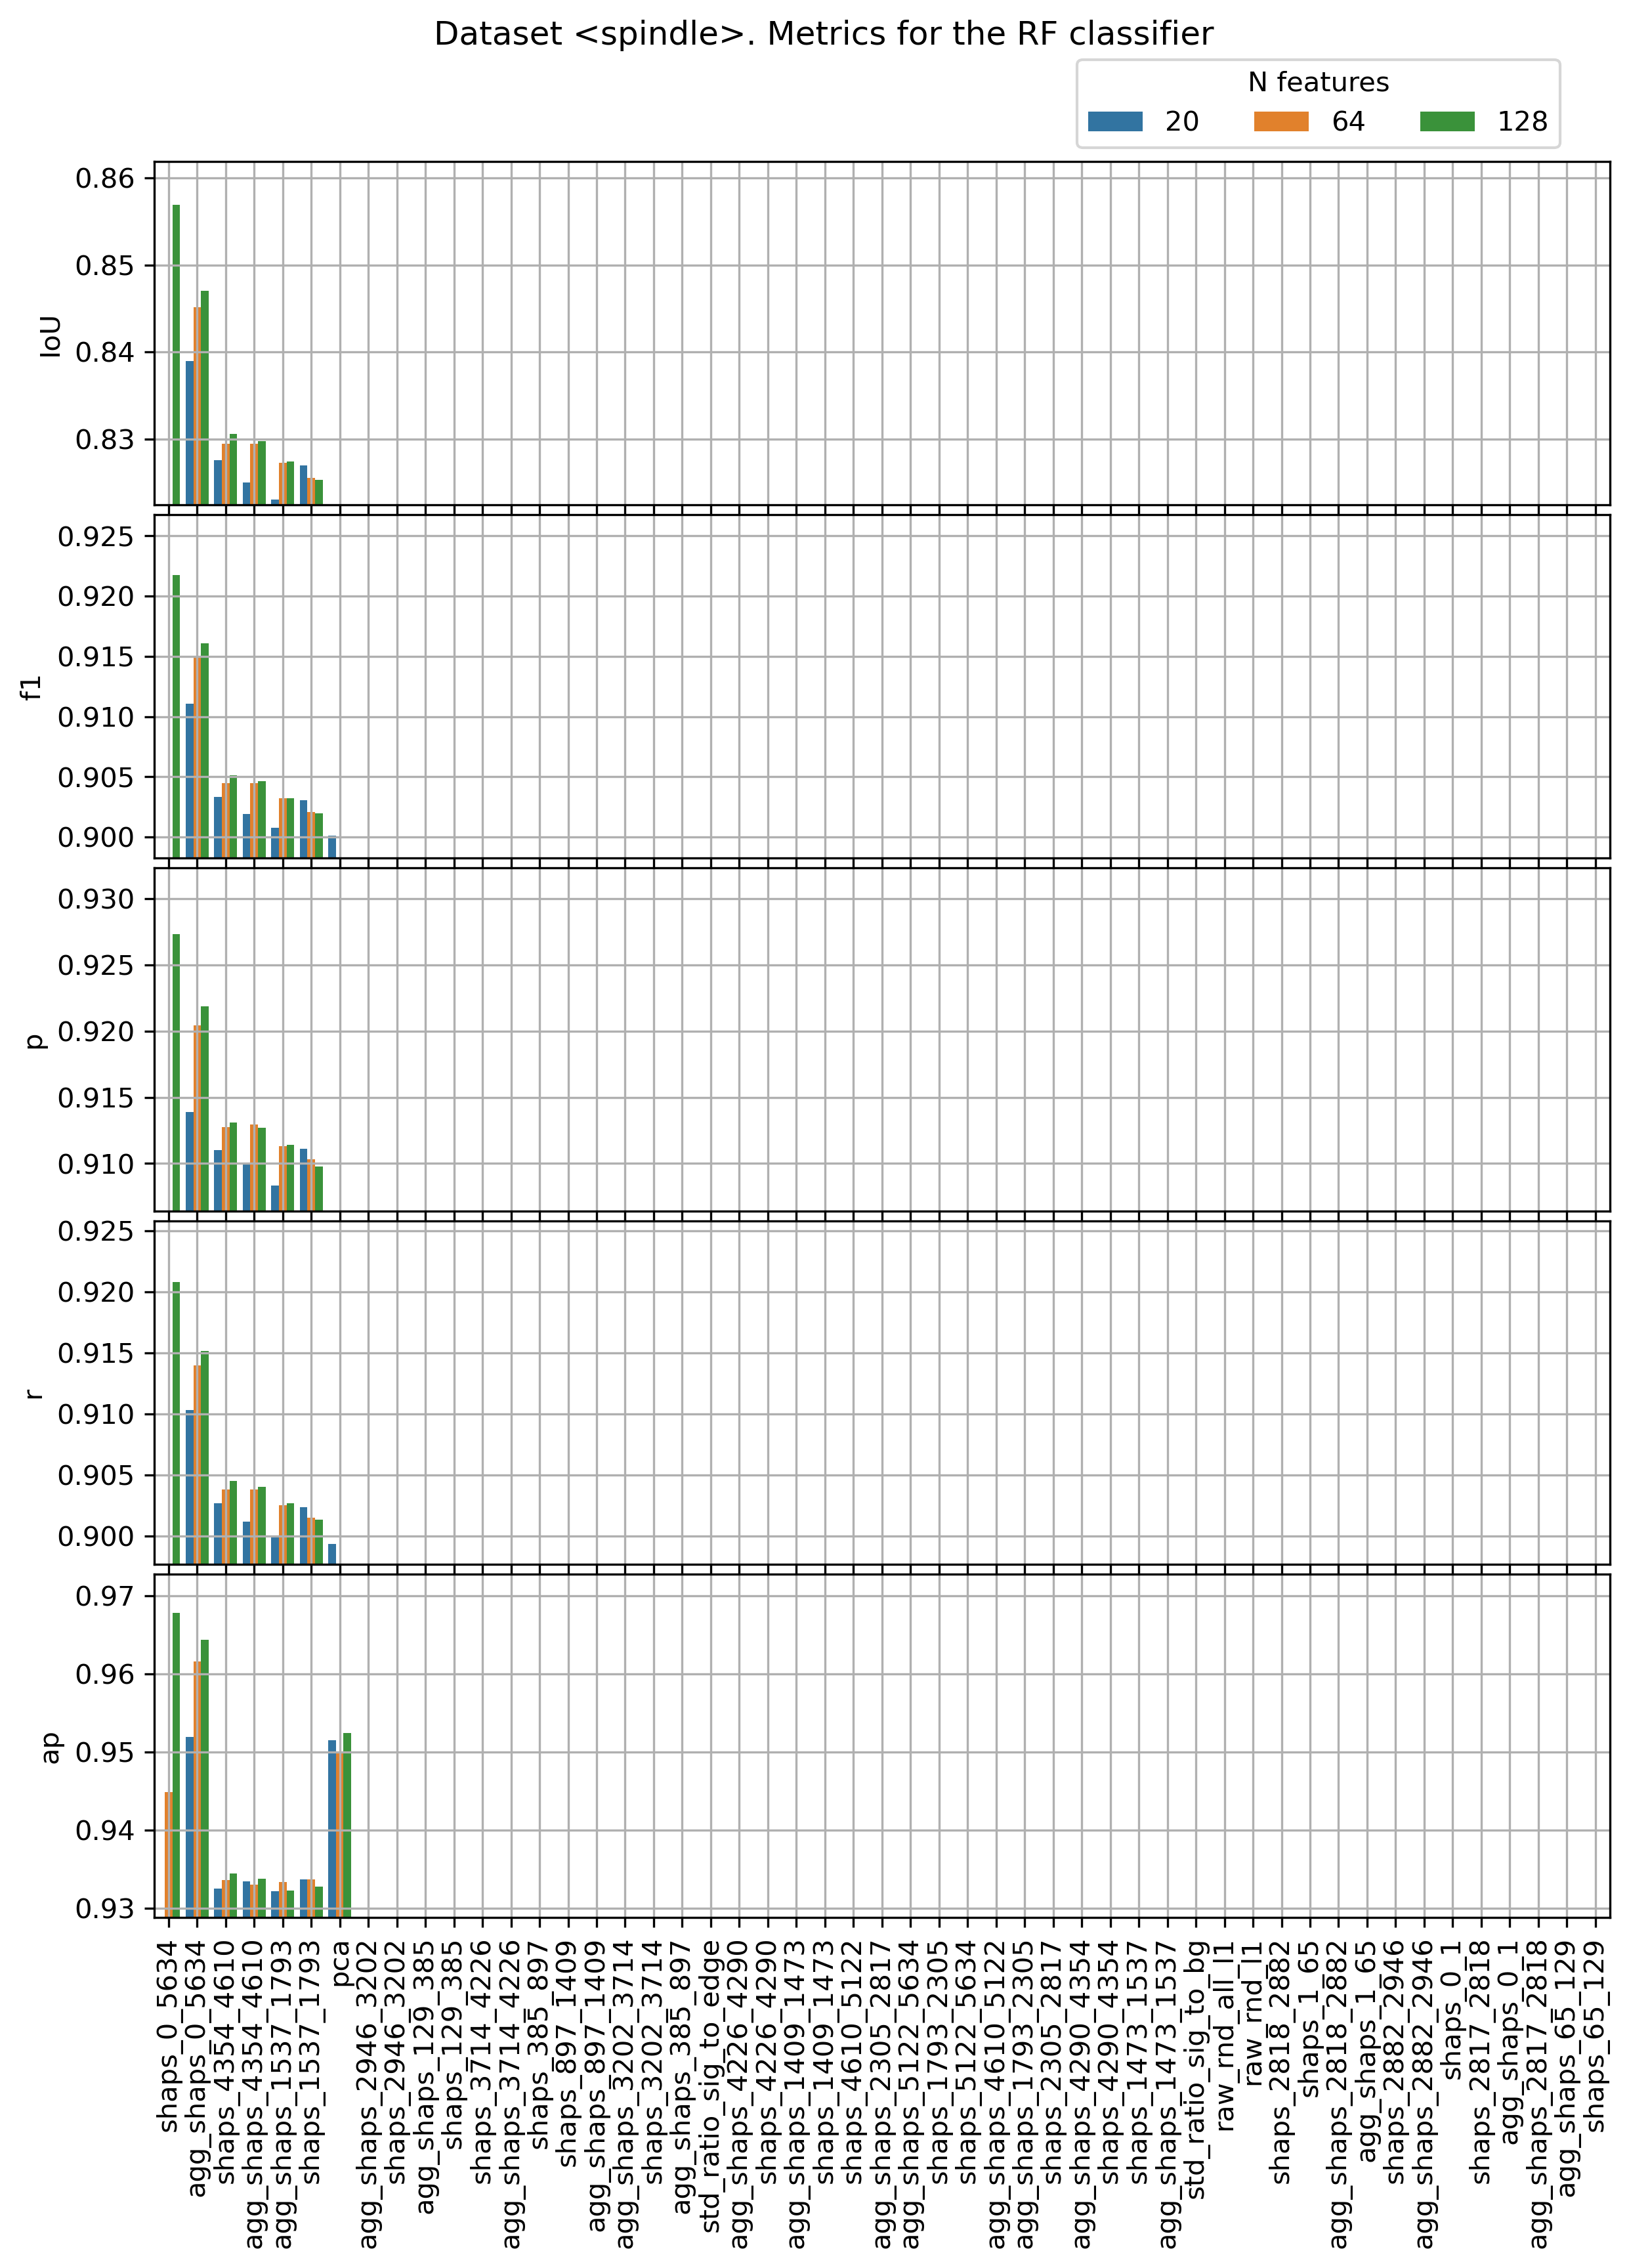

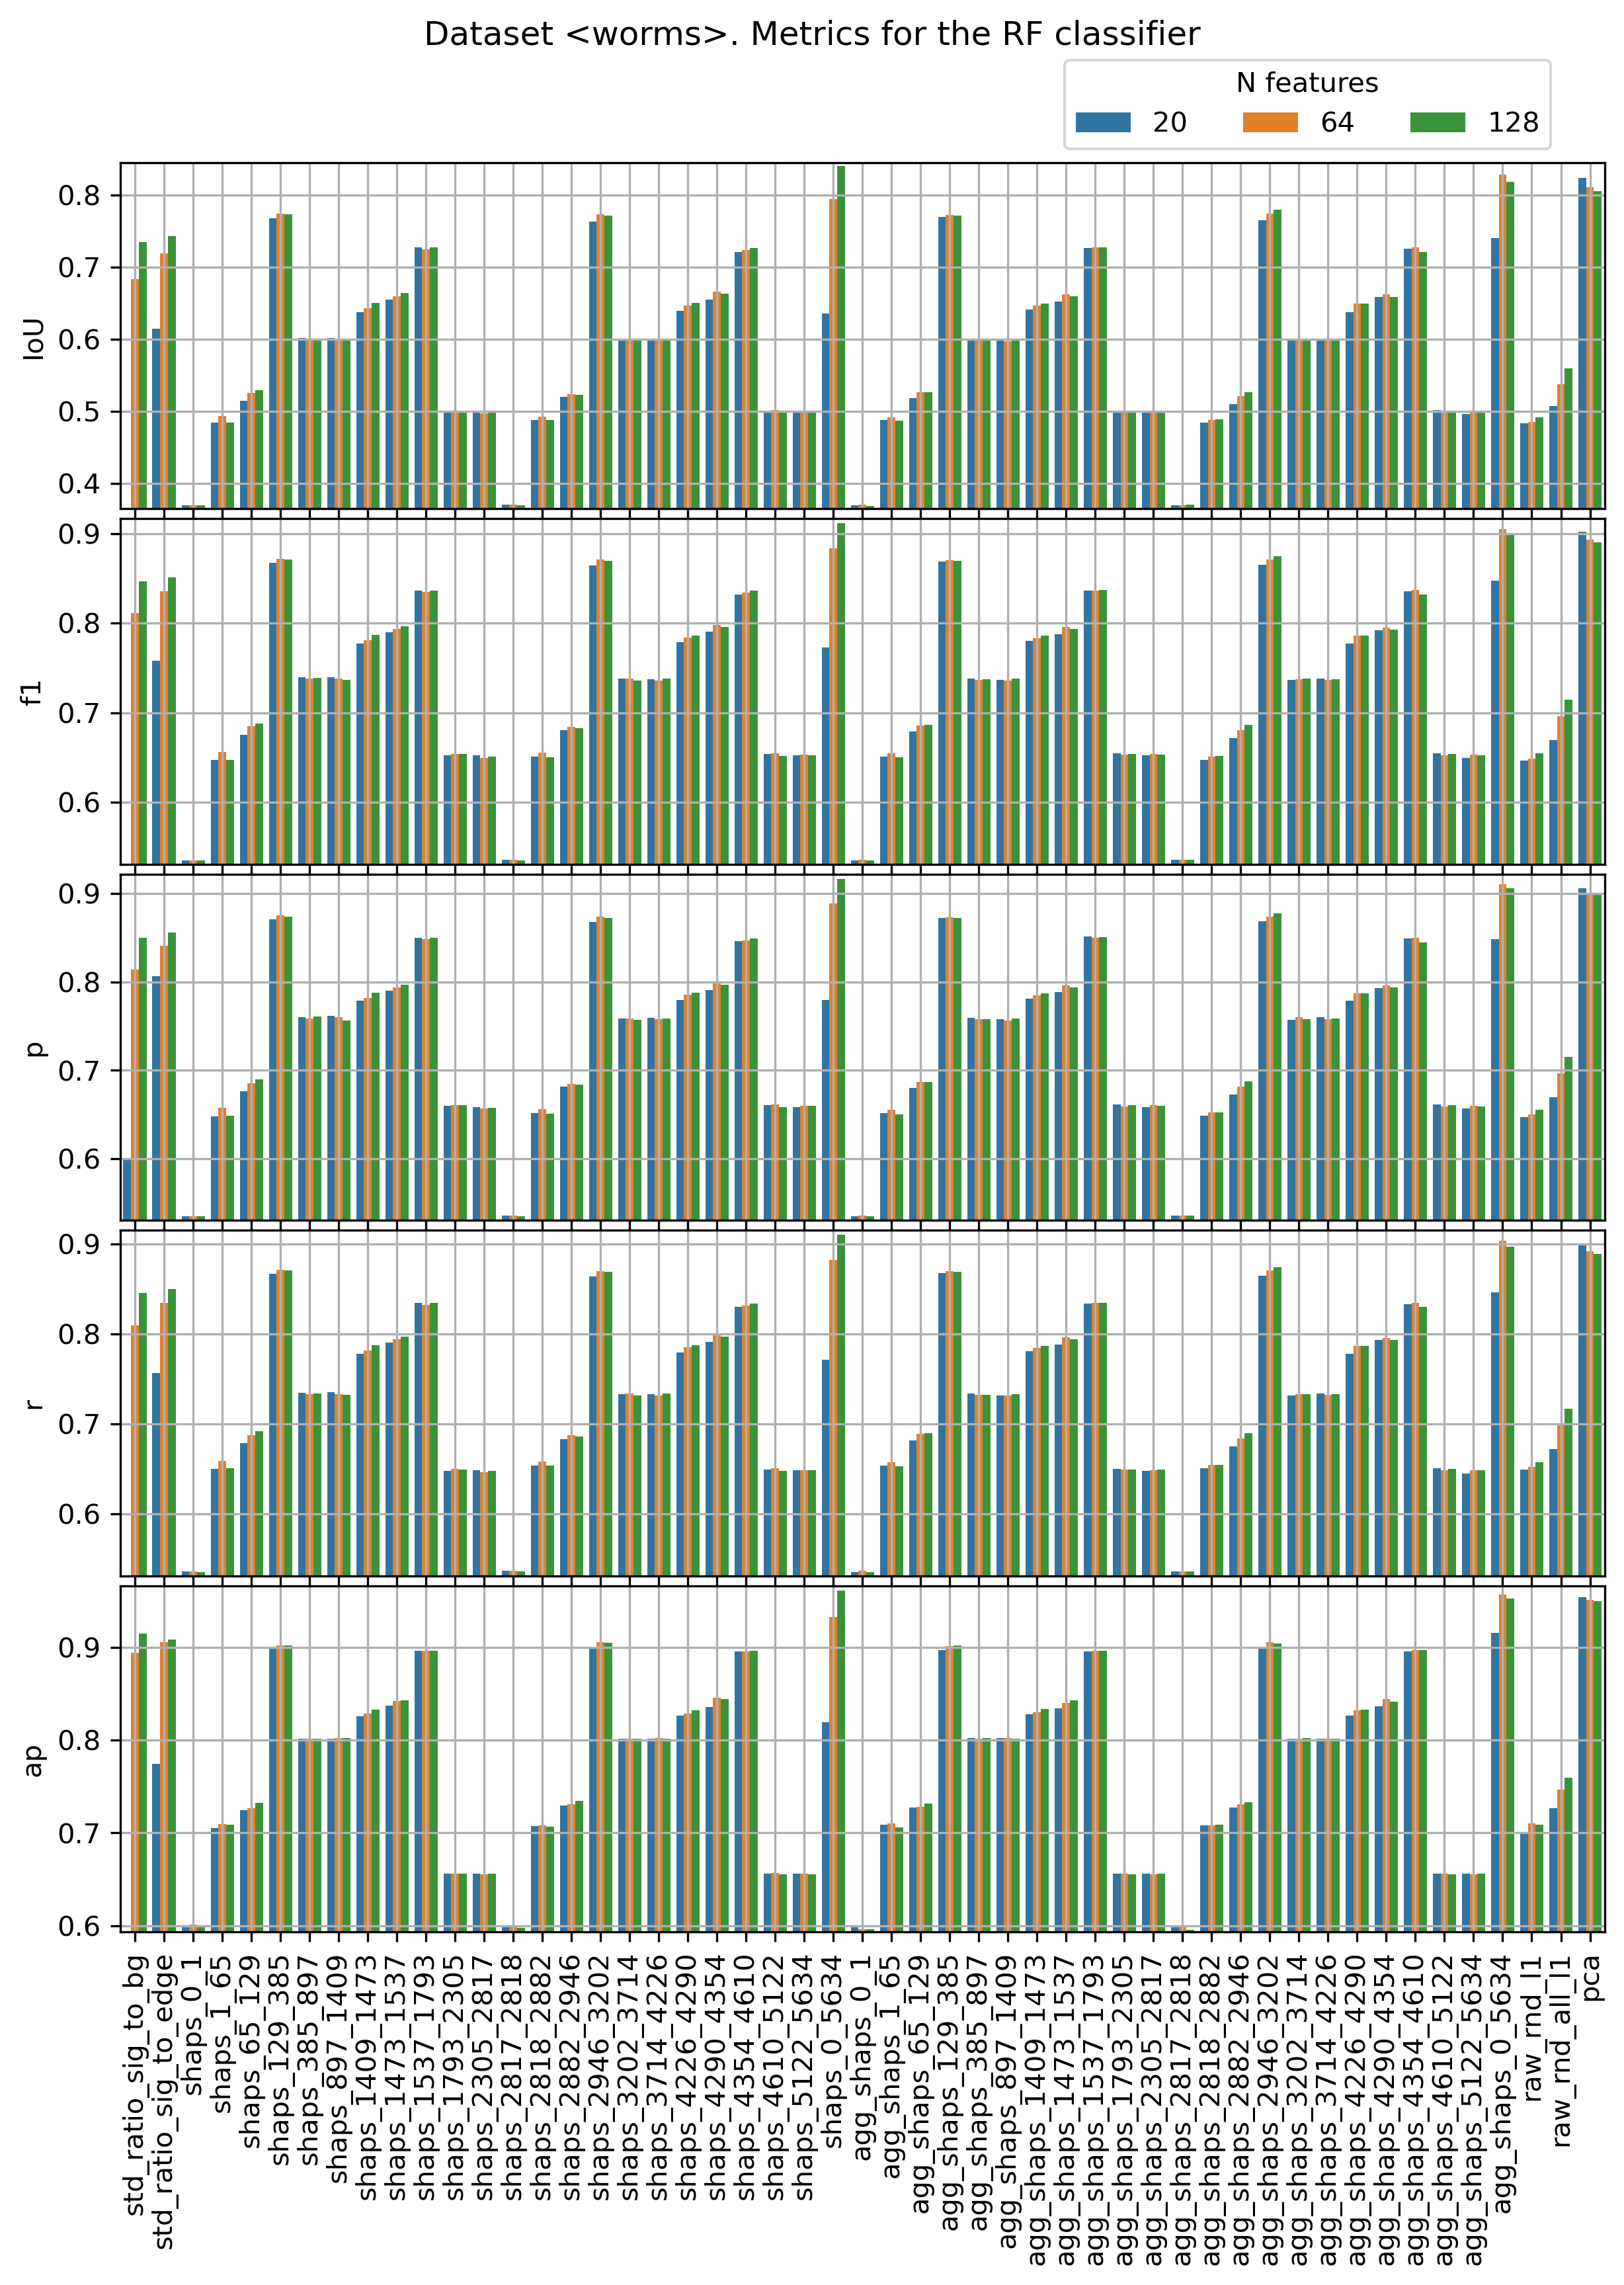

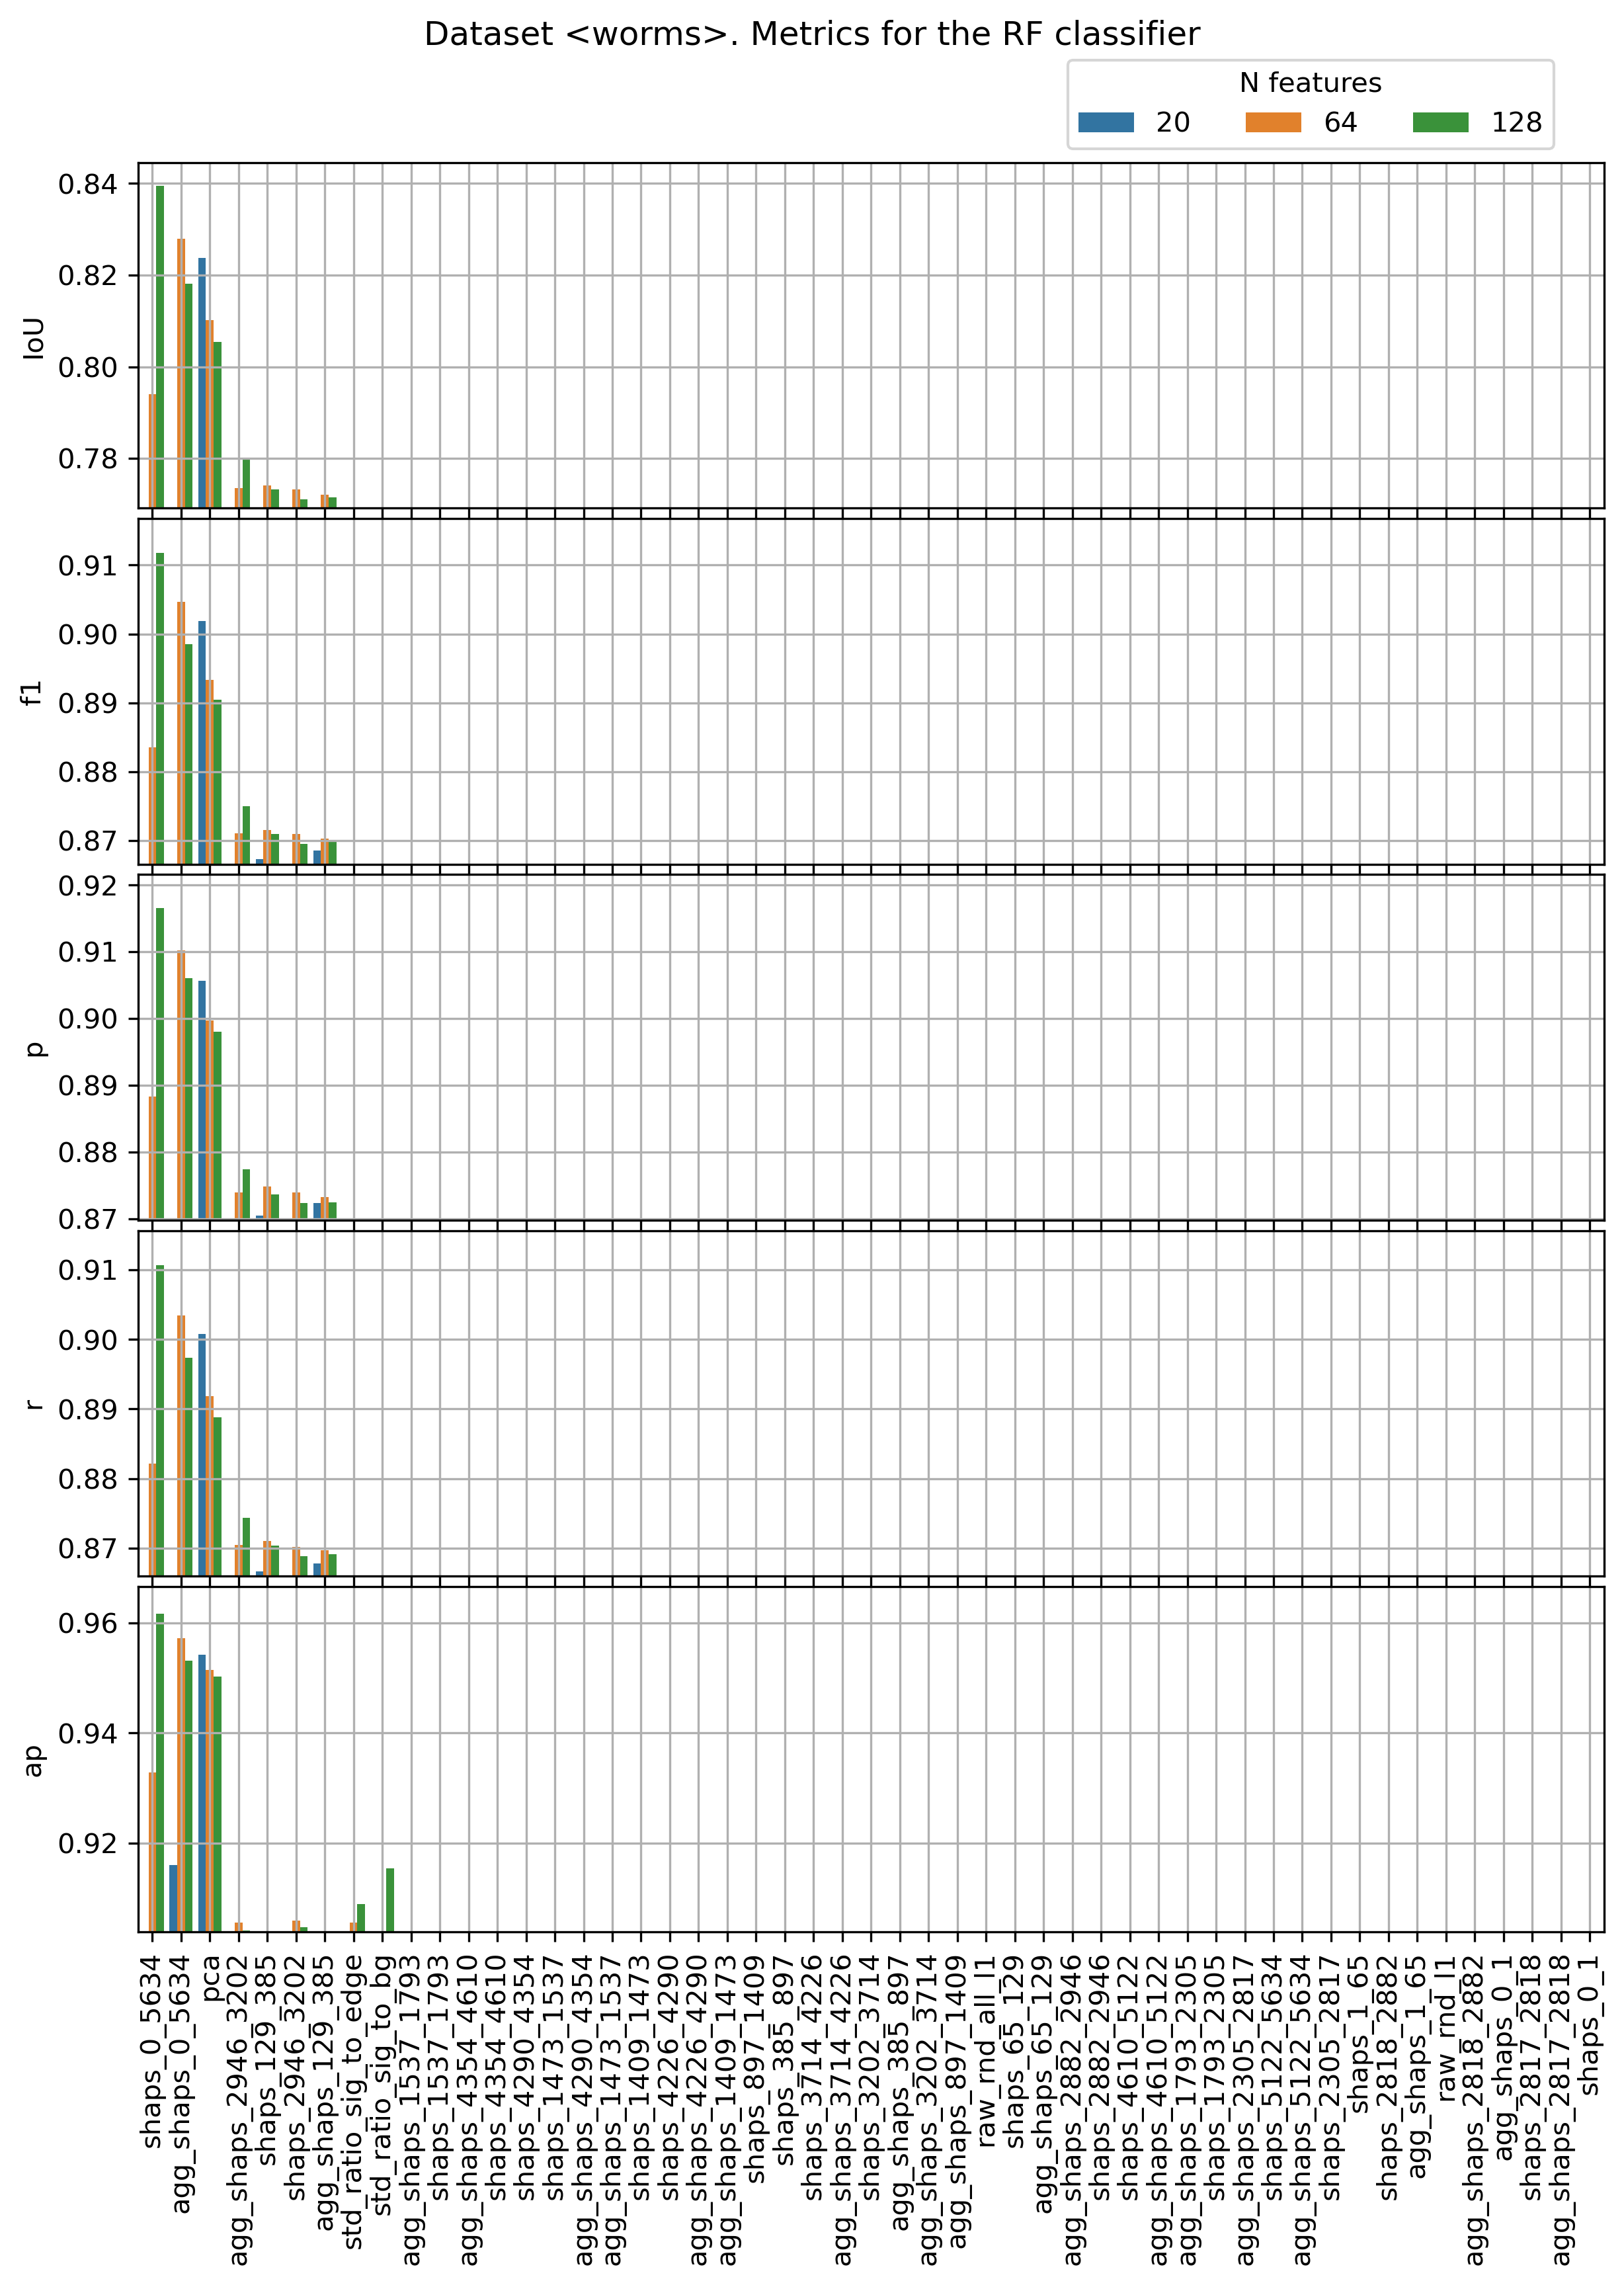

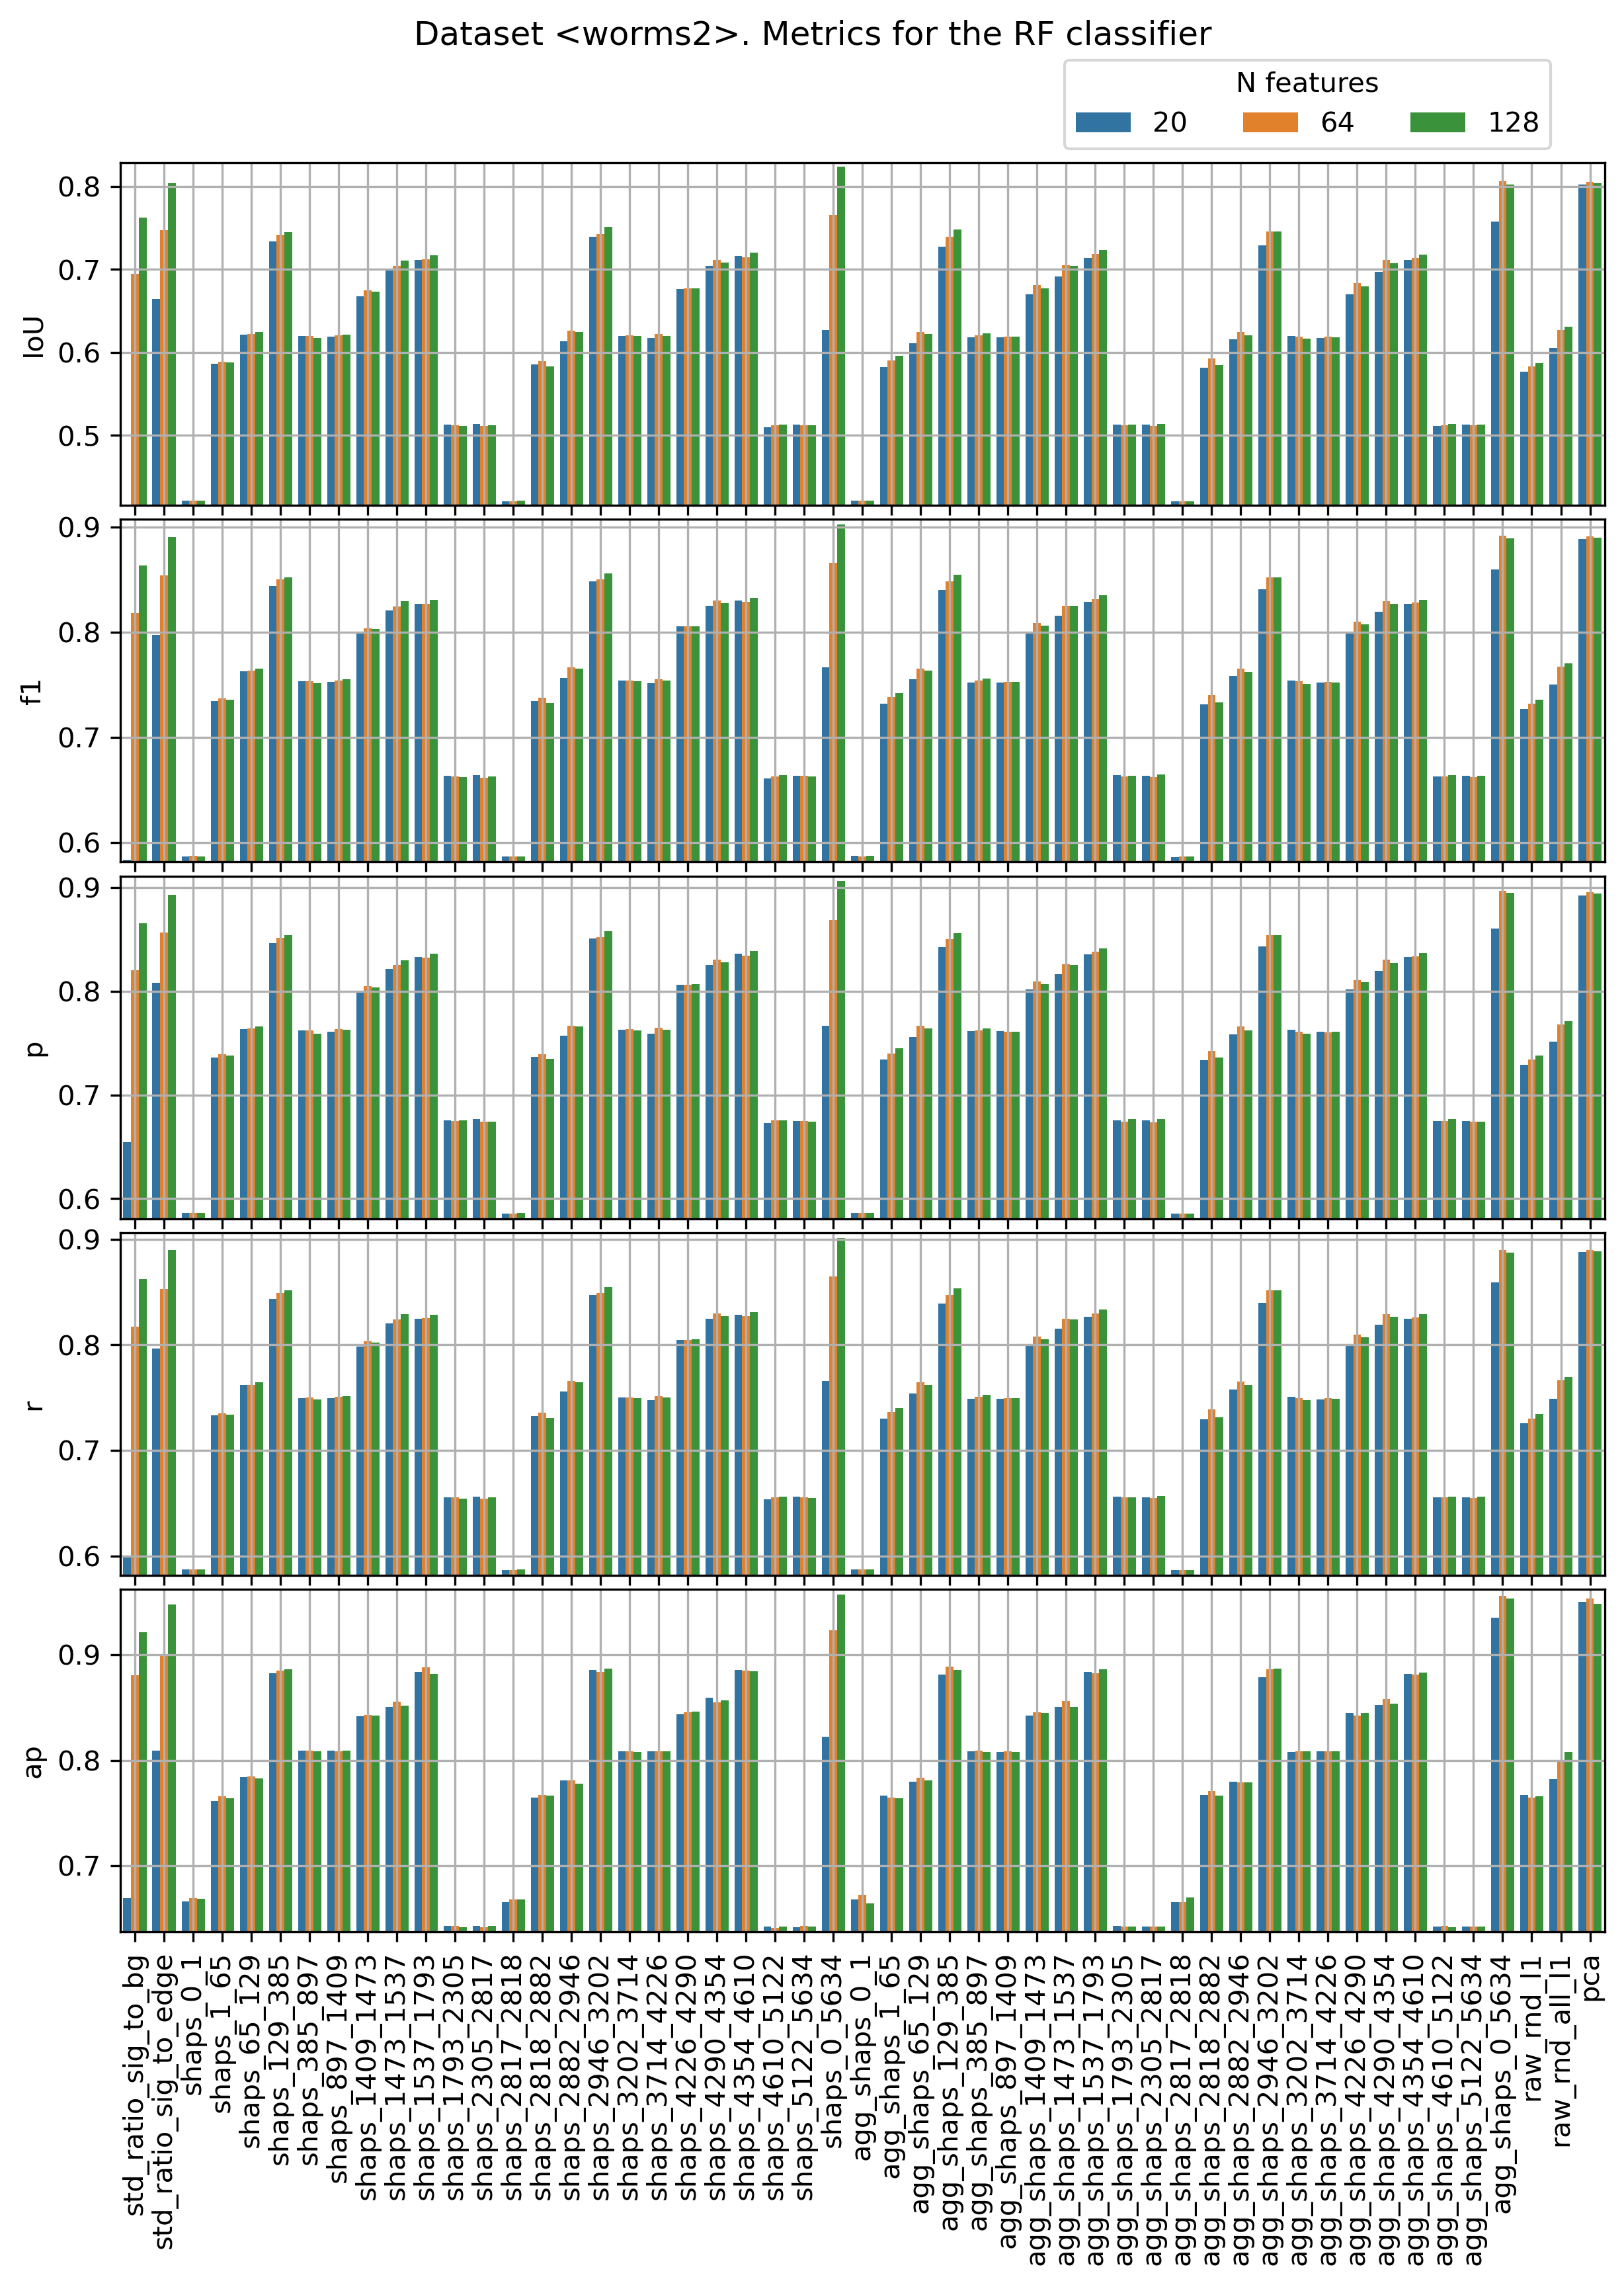

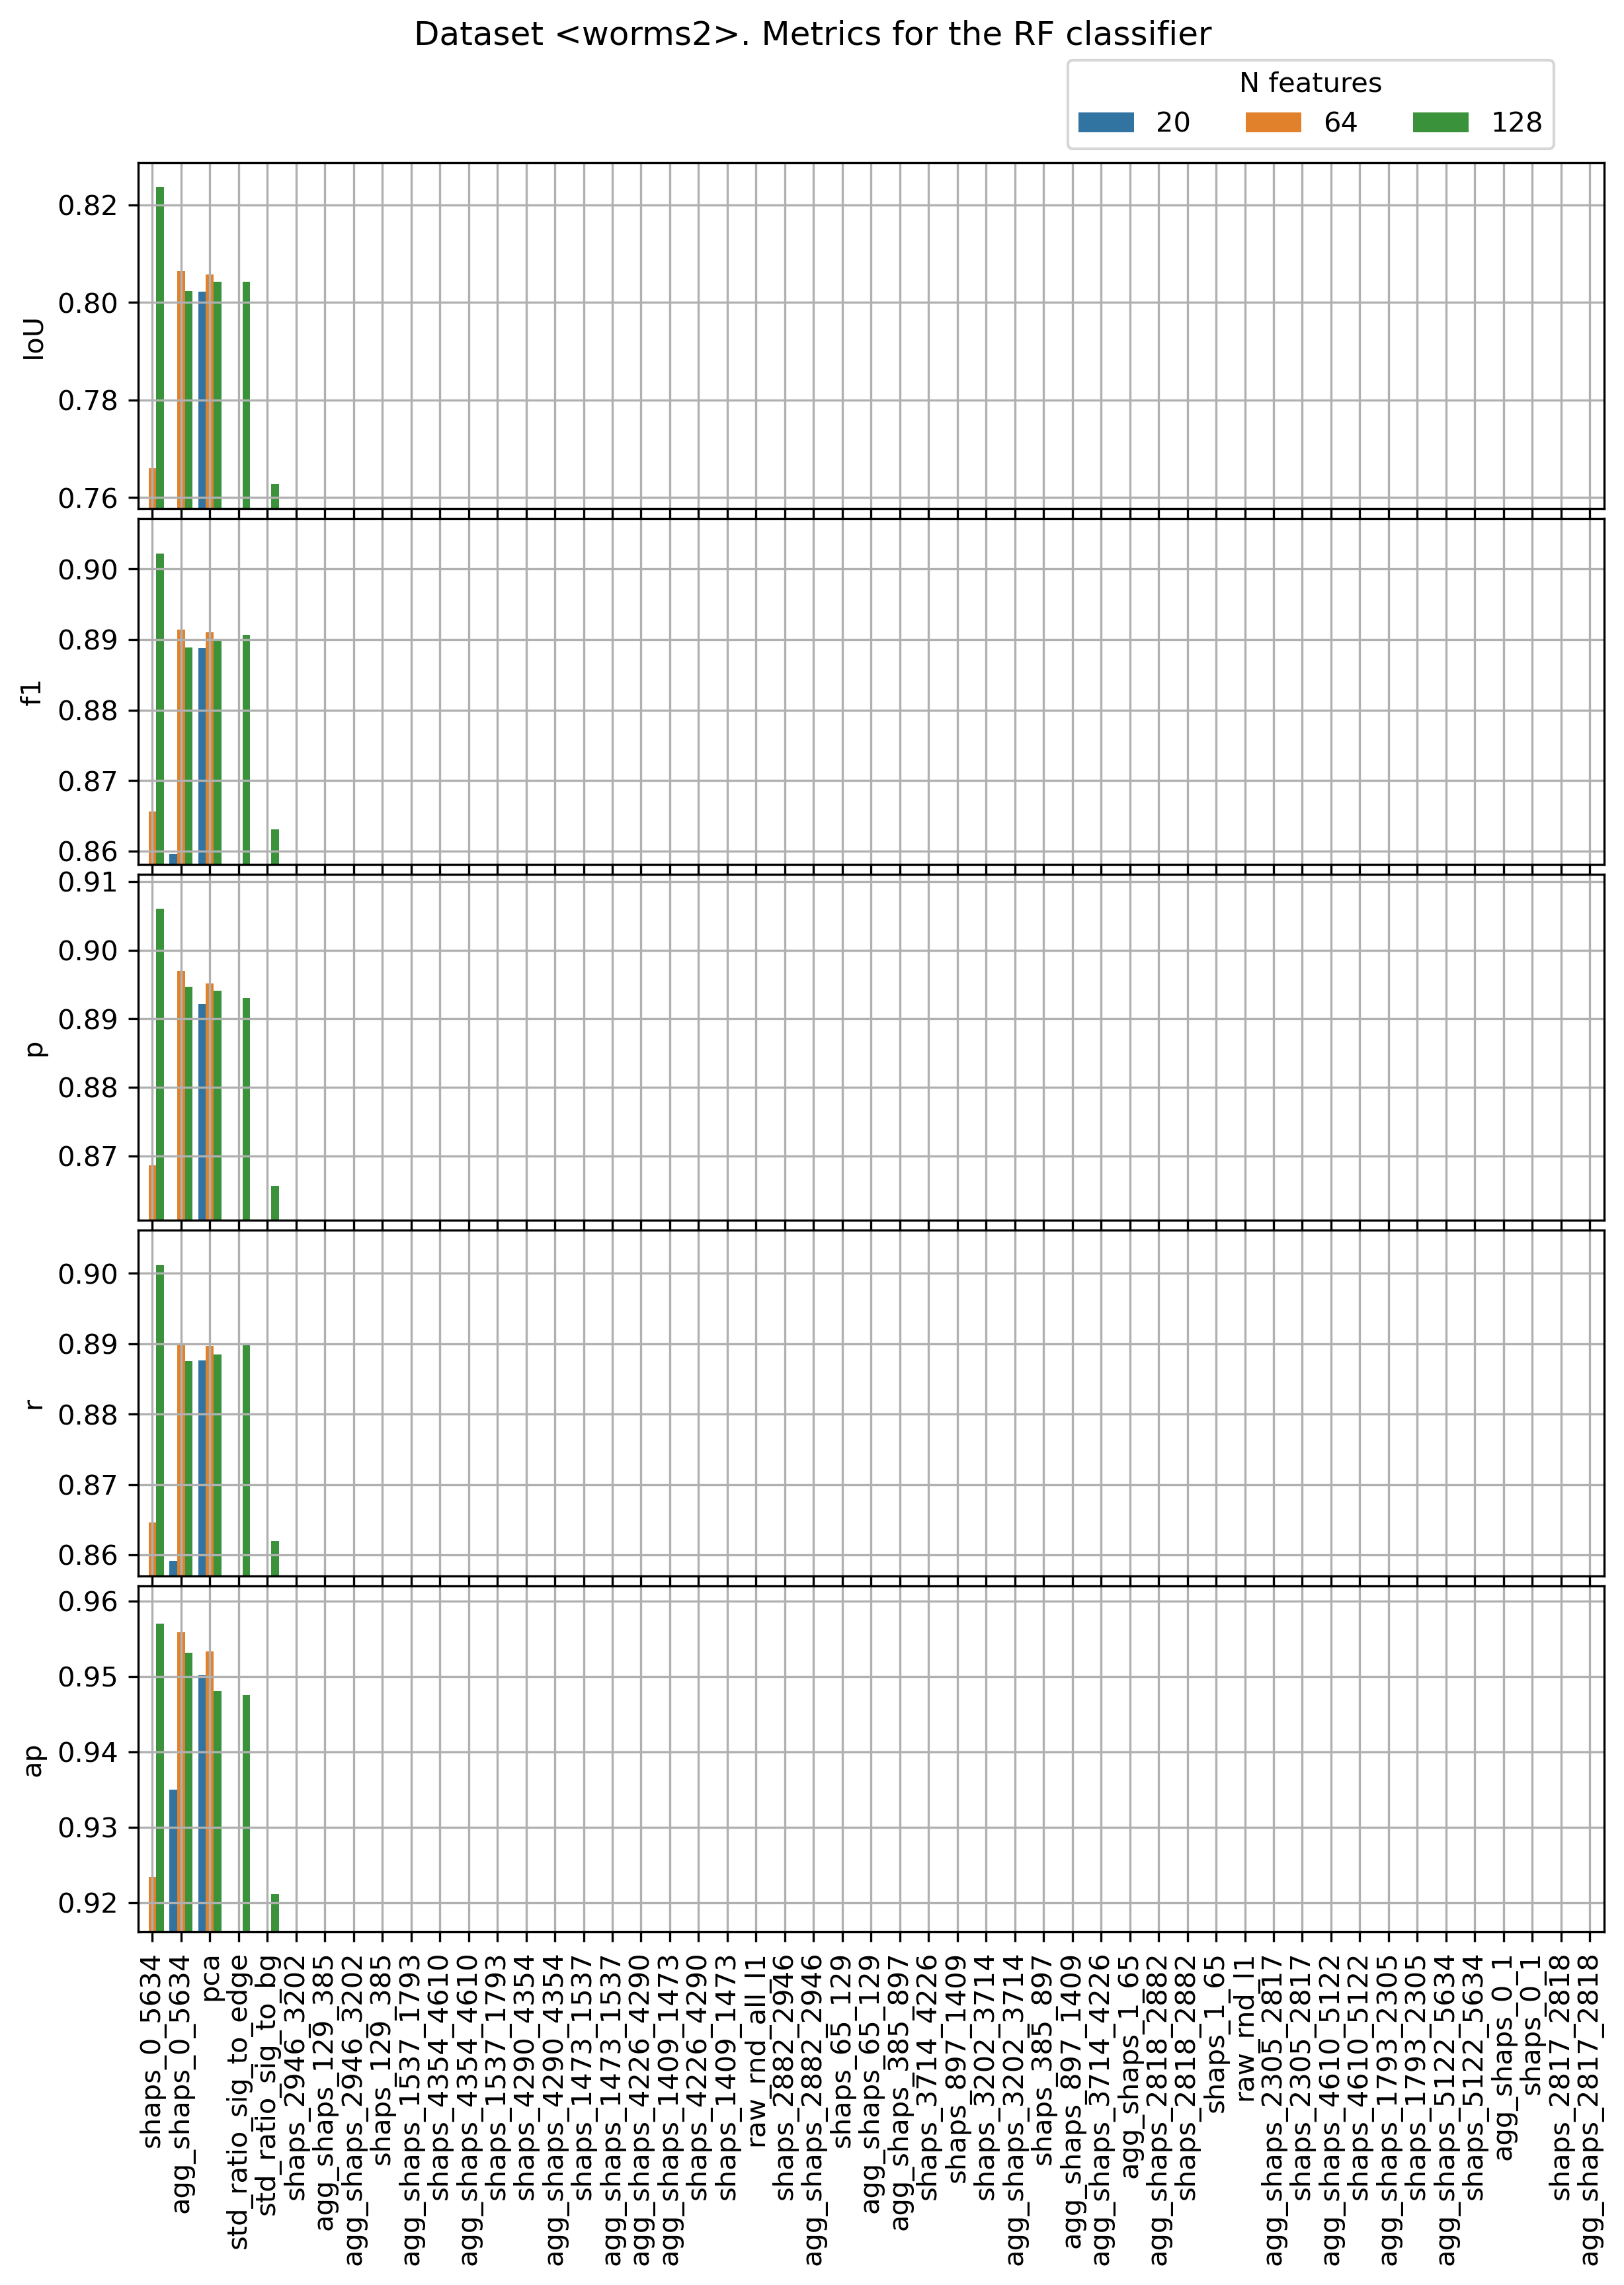

In [92]:
# create multipage pdf with plots for each dataset

with PdfPages(data_root/'features'/'metrics_evaluation.pdf') as pdf:
    for ds in perf_eval.keys():
        plot_metric(df[df['dataset']==ds], ds, y_strategy='fit', pdf=pdf)
        plot_metric(df[df['dataset']==ds], ds, y_strategy=5, x_strategy='IoU', pdf=pdf)

# inspect where are selected features located in the layer structure

In [9]:
selected_strategy_name ='agg_shaps_0_5634' 
strategies_mask = np.array(perf_eval['actin'][128]['strategy_name']) == selected_strategy_name
selected_strategy_idx = np.argwhere(strategies_mask)[0][0]

In [11]:
selected_strategy_idx

47

In [12]:
perf_eval['actin'][128]['strategy_name'][selected_strategy_idx]

'agg_shaps_0_5634'

In [13]:
perf_eval['actin'][128]['metrics'][selected_strategy_idx]

{'f1': 0.9872224328893614,
 'ap': 0.9981070058677146,
 'p': 0.9876049532665834,
 'r': 0.9871666666666666,
 'IoU': 0.9748081008576556,
 'cm': array([[1935,    0,   43],
        [   0, 2010,   32],
        [   1,    1, 1978]], dtype=int64)}

In [14]:
selected_features = perf_eval['actin'][128]['column_idxs'][selected_strategy_idx]

In [15]:
# map of block names to range of global indeces of features in that block
blocks = {
'raw_+': (0, 1),
'L_00__s1__+': (1, 65),
'L_02__s1__+': (65, 129),
'L_12__s1__+': (129, 385),
'L_26__s1__+': (385, 897),
'L_28__s1__+': (897, 1409),
'L_00__s2__+': (1409, 1473),
'L_02__s2__+': (1473, 1537),
'L_12__s2__+': (1537, 1793),
'L_26__s2__+': (1793, 2305),
'L_28__s2__+': (2305, 2817),
'raw_-': (2817, 2818),
'L_00__s1__-': (2818, 2882),
'L_02__s1__-': (2882, 2946),
'L_12__s1__-': (2946, 3202),
'L_26__s1__-': (3202, 3714),
'L_28__s1__-': (3714, 4226),
'L_00__s2__-': (4226, 4290),
'L_02__s2__-': (4290, 4354),
'L_12__s2__-': (4354, 4610),
'L_26__s2__-': (4610, 5122),
'L_28__s2__-': (5122, 5634),
}

In [17]:
# given block names and start and end values of block, make fn to convert indeces of selected features to block names
def idx_to_block_name_local_idx(idx, blocks):
    for block_name, (start, end) in blocks.items():
        if idx >= start and idx < end:
            return block_name, idx - start
    return None

block_names_idx = [idx_to_block_name_local_idx(idx, blocks) for idx in selected_features]

In [18]:
block_names = [block_name for block_name, _ in block_names_idx]
local_idx = [local_idx for _, local_idx in block_names_idx]

In [22]:
save_pckl({'block_names': block_names, 'local_idx': local_idx},
          'selected_features_agg_shaps_0_5634.pckl', path=data_root/'features')

In [23]:
# count how many features are selected from each block
from collections import Counter
c = Counter(block_names)

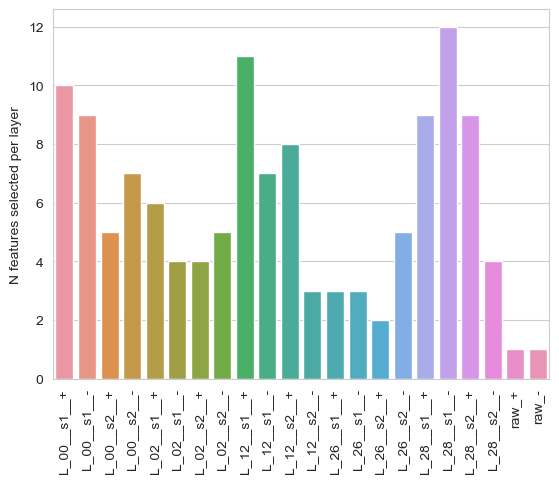

In [24]:
#sns.barplot(x=list(c.keys()), y=list(c.values()), order=blocks.keys())
sns.barplot(x=list(c.keys()), y=list(c.values()), order=sorted(blocks.keys()))
#rotate x labels
plt.xticks(rotation=90);
#set y label
plt.ylabel('N features selected per layer');